# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=10):
    data = StockDataProvider(ticker_name, start=start, end=end)
    optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
    print('Running genetic algorithm ...')
    hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3)
    print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
    gbm = GeometricBrownianMotion(data)
    crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
    print('Running backtesting ...')
    best_individual = crossvalidator.run(num_iterations=100, time_steps=252)
    del data
    del optimizer
    del gbm
    del crossvalidator    
    return best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	647   	-68.2149	22.0738	-17.1252	14.0355
2  	648   	-113.777	26.7178	-8.02238	12.5078
3  	669   	-113.777	29.4437	-2.75432	11.9377
4  	659   	-113.899	37.1837	0.742014	10.6876
5  	645   	-112.792	37.1837	3.7884  	11.2563
6  	642   	-112.792	34.3069	6.4109  	12.0583
7  	637   	-67.5332	34.6216	9.68119 	12.5808
8  	663   	-113.777	44.0883	12.2534 	14.0081
9  	651   	-63.1681	44.0883	15.1675 	12.8425
10 	655   	-116.024	38.7978	16.7469 	15.0648
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Best average net profit: 3.3048711524857026
CPU times:

In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[228], [24, 44, 72], [51, 4]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 0
Number of sell signals: 0


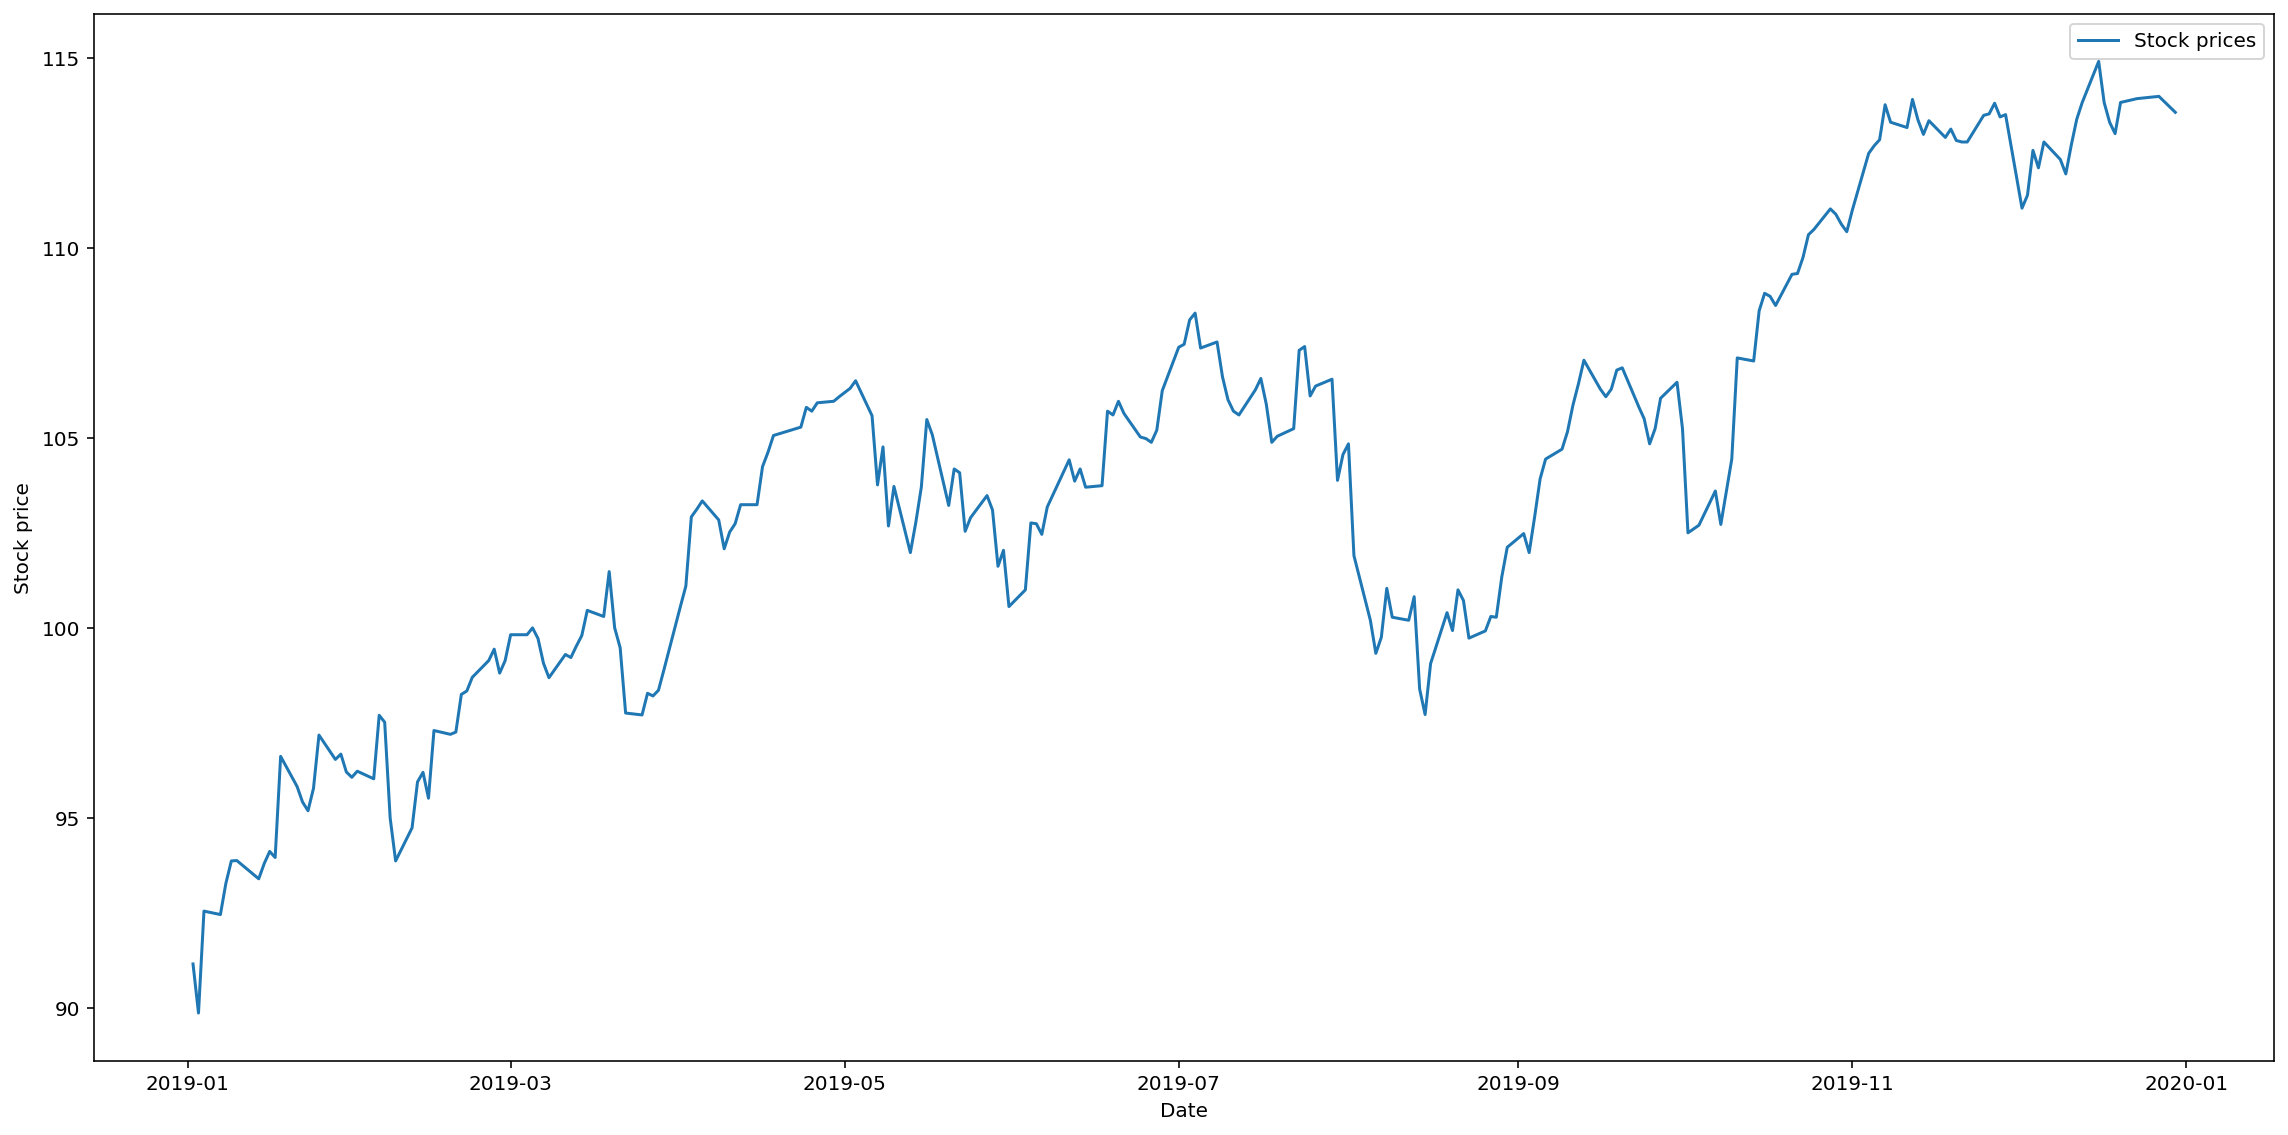

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=10)

/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.46141	35.9584
1  	647   	-140.242	104.282	18.4735 	28.9277
2  	648   	-139.276	115.915	32.0859 	26.9895
3  	669   	-140.289	118.468	42.9047 	27.8845
4  	659   	-137.19 	118.468	53.5652 	28.6967
5  	645   	-149.685	118.468	62.0178 	29.0989
6  	642   	-143.155	118.468	70.3161 	27.334 
7  	637   	-130.257	118.468	74.4954 	28.5622
8  	663   	-79.3128	122.977	80.0428 	26.2183
9  	651   	-71.1993	122.977	84.6223 	25.8264
10 	655   	-134.153	126.927	86.6514 	29.6289
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
Best average net profit: 19.928452352345325
CPU times: user 8m

In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[160], [27, 50, 14], [172, 125, 60], [58, 5]]
Net profit of strategy: 10.342975
Net profit of buy and hold: 104.593925
Percentage profit of strategy: 5.799582%
Percentage profit of buy and hold: 58.648607%
Number of buy signals: 7
Number of sell signals: 7


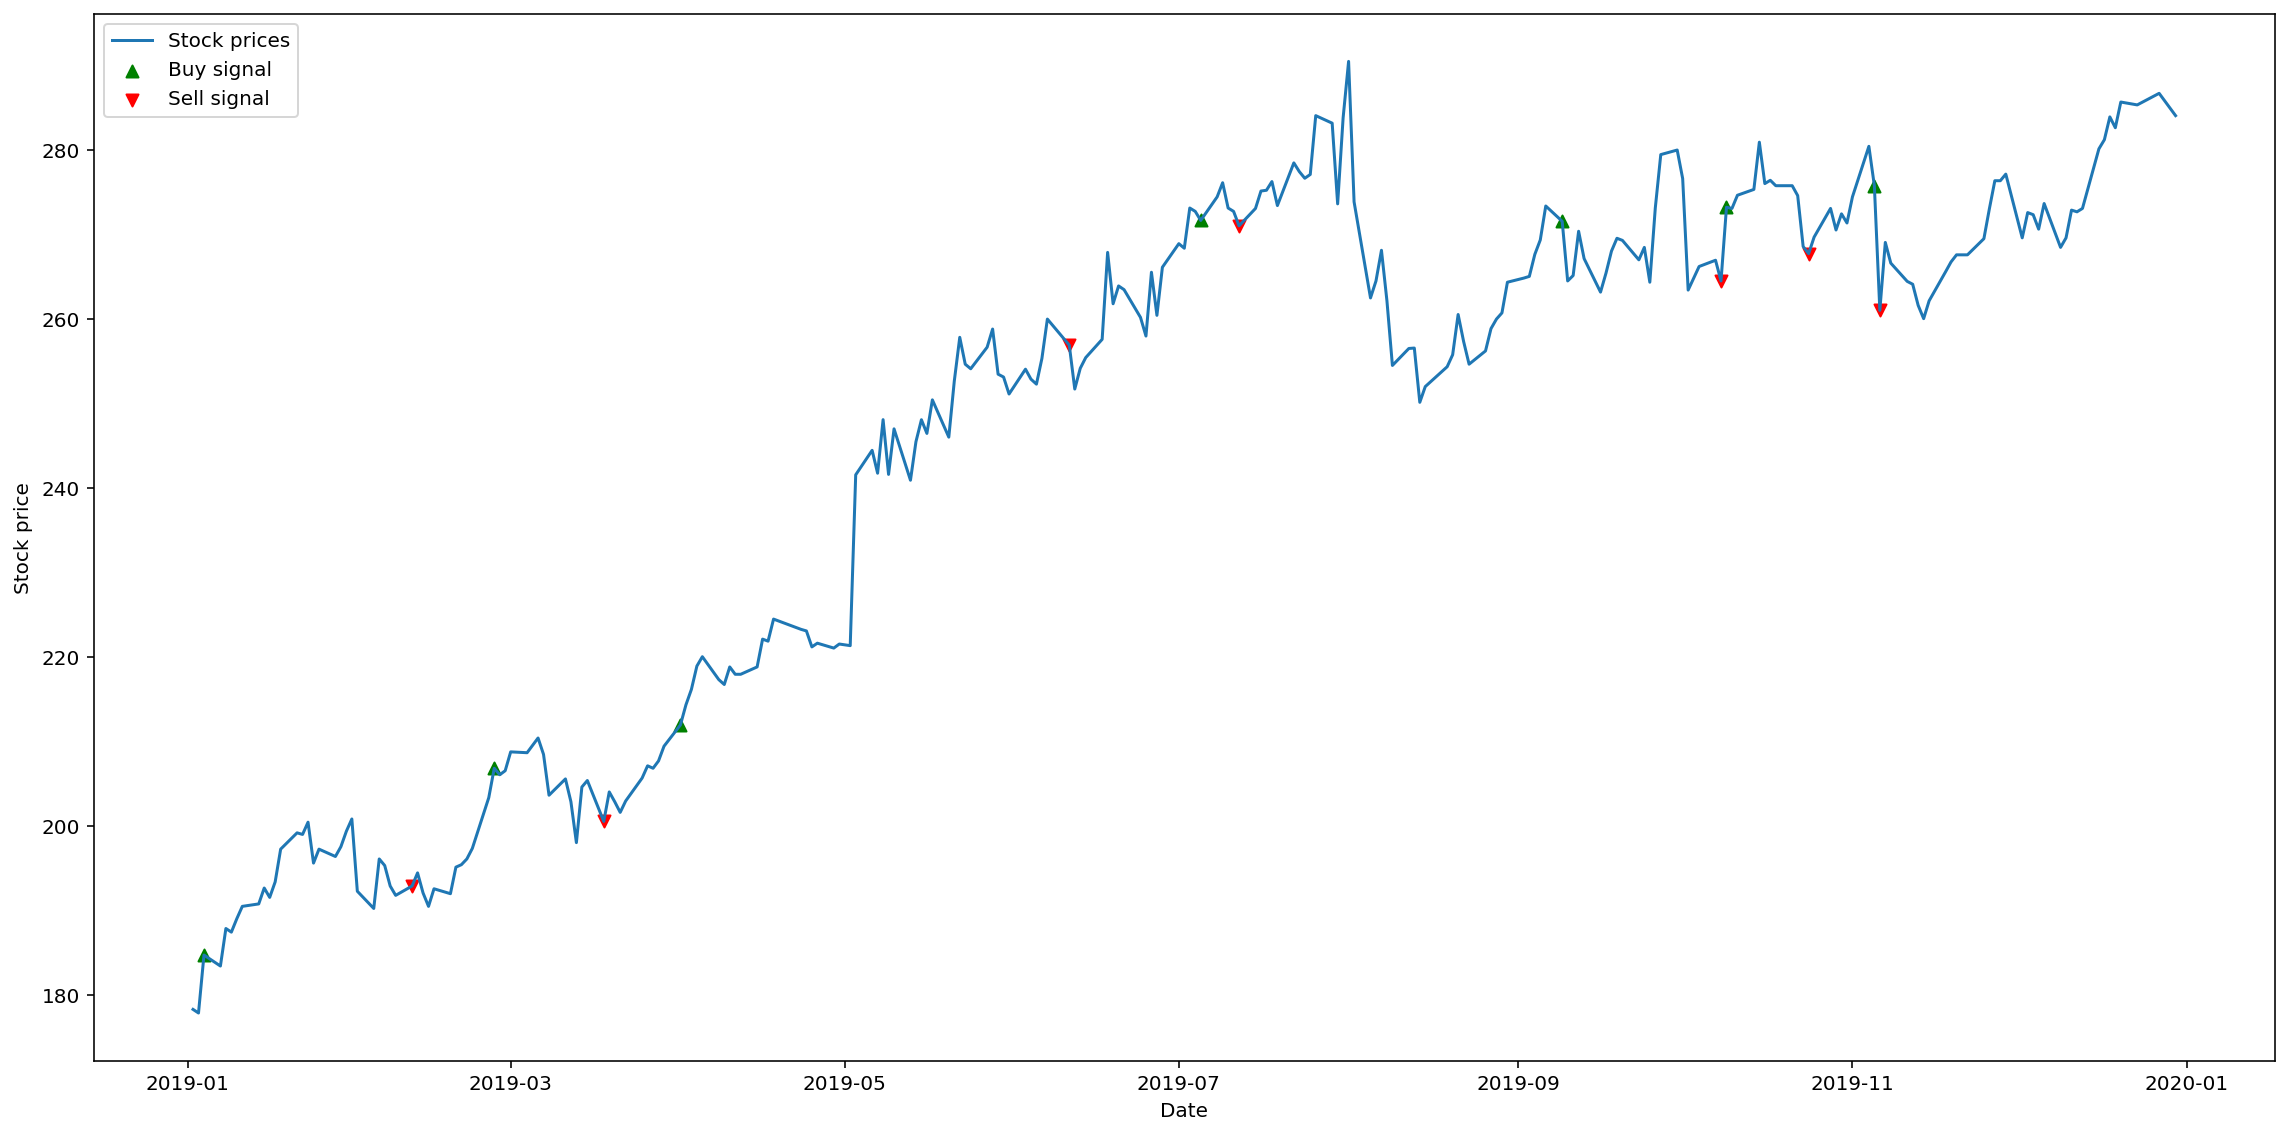

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148	-18.9056	23.3736
1  	647   	-75.6499	56.3798	-2.53113	18.1415
2  	648   	-120.137	61.6673	8.16497 	19.3467
3  	669   	-122.996	58.9658	16.5632 	19.7787
4  	659   	-119.95 	62.1555	23.7642 	18.486 
5  	645   	-119.39 	69.989 	29.785  	19.5364
6  	642   	-47.0347	69.989 	35.1966 	19.115 
7  	637   	-71.9665	70.6374	40.4486 	19.3948
8  	663   	-46.9478	80.8444	45.1711 	19.4738
9  	651   	-46.9478	81.9292	48.3984 	20.0646
10 	655   	-66.7964	81.9292	51.4818 	21.1028
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0]
Best average net profit: 4.544287682242278
CPU times: us

In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[36, 62, 122], [150], [11, 3]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 47.002725
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 29.843000%
Number of buy signals: 0
Number of sell signals: 0


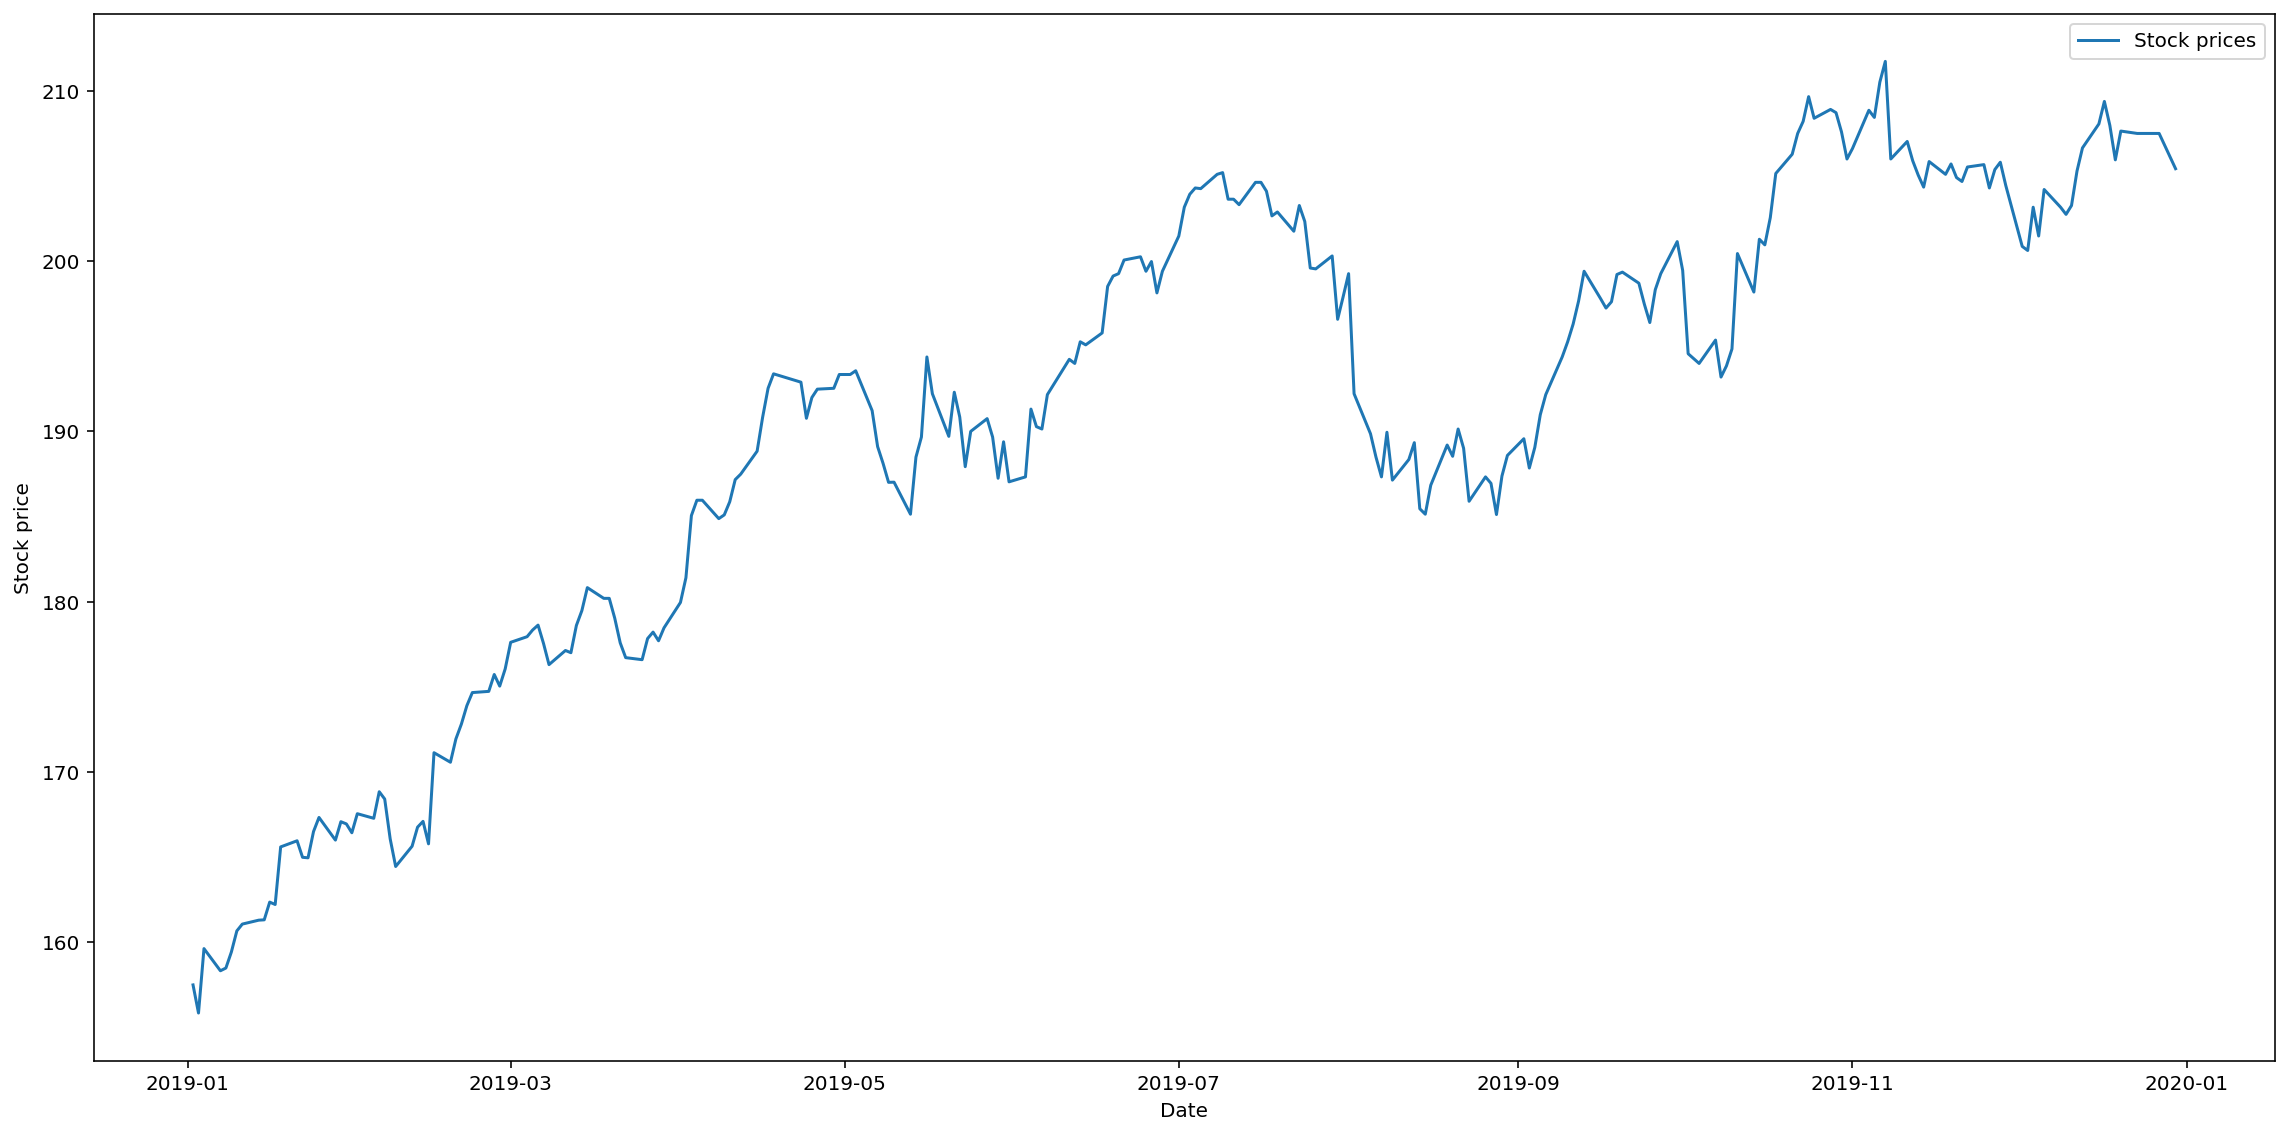

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-67.1786	17.4502	-12.4406	12.3205
1  	647   	-59.4267	19.1619	-4.31795	9.21455
2  	648   	-67.0082	19.3982	0.687236	9.10234
3  	669   	-59.0443	24.6319	4.72544 	8.42348
4  	659   	-59.4267	25.5234	7.63261 	9.11758
5  	645   	-39.649 	28.0865	10.6136 	8.30052
6  	642   	-56.3669	29.0106	12.6892 	8.87447
7  	637   	-58.7963	33.9827	14.3867 	9.57334
8  	663   	-57.8363	34.2378	15.9907 	10.3107
9  	651   	-44.47  	34.2378	17.9926 	10.2436
10 	655   	-31.266 	34.2378	19.6581 	9.97749
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Best average net profit: 3.179123076534868
CPU time

In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[7, 43, 89], [28, 6]]
Net profit of strategy: 6.531850
Net profit of buy and hold: 7.846450
Percentage profit of strategy: 12.896051%
Percentage profit of buy and hold: 15.491510%
Number of buy signals: 1
Number of sell signals: 1


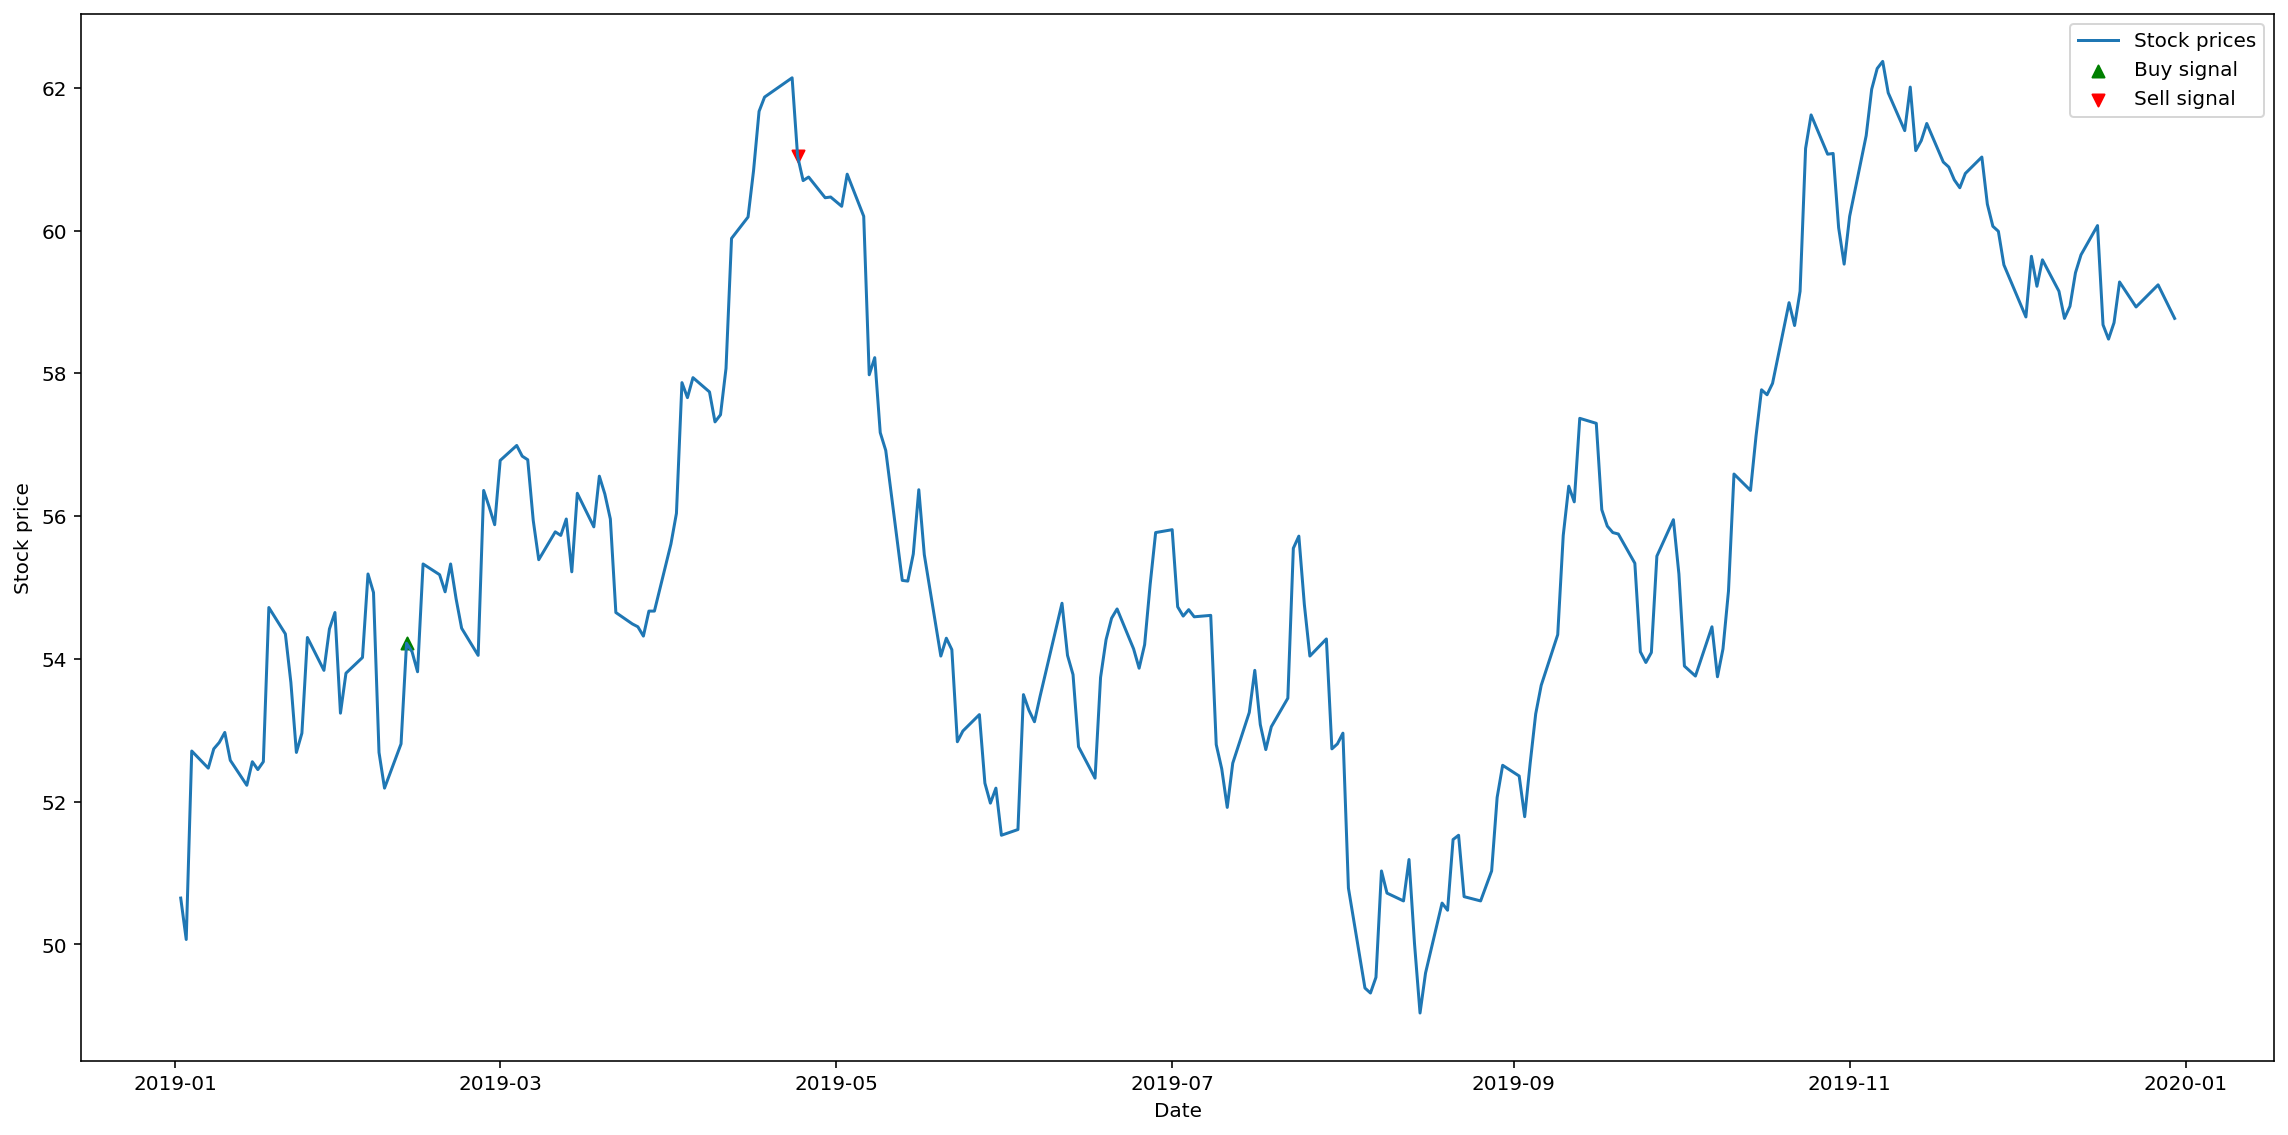

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	-4.7023	3.2932
1  	647   	-14.4912	3.52672	-2.59794	2.74614
2  	648   	-13.1124	4.22185	-1.20638	2.47349
3  	669   	-13.2709	5.19232	-0.297019	2.22954
4  	659   	-10.9019	6.61455	0.209062 	2.31825
5  	645   	-11.9671	6.11835	0.530504 	2.68701
6  	642   	-13.4734	6.98912	1.05625  	2.61677
7  	637   	-9.84882	6.98912	1.47863  	2.55539
8  	663   	-10.6274	7.10968	1.73773  	2.68018
9  	651   	-11.3079	7.10968	2.01417  	2.72044
10 	655   	-8.54413	8.38583	2.37751  	2.67395
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
Best average net profit: -0.20831359251849763
CPU times: u

In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[187], [38, 32, 36], [95, 34, 72], [7, 0]]
Net profit of strategy: -0.503200
Net profit of buy and hold: -0.144875
Percentage profit of strategy: -7.157895%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 9
Number of sell signals: 9


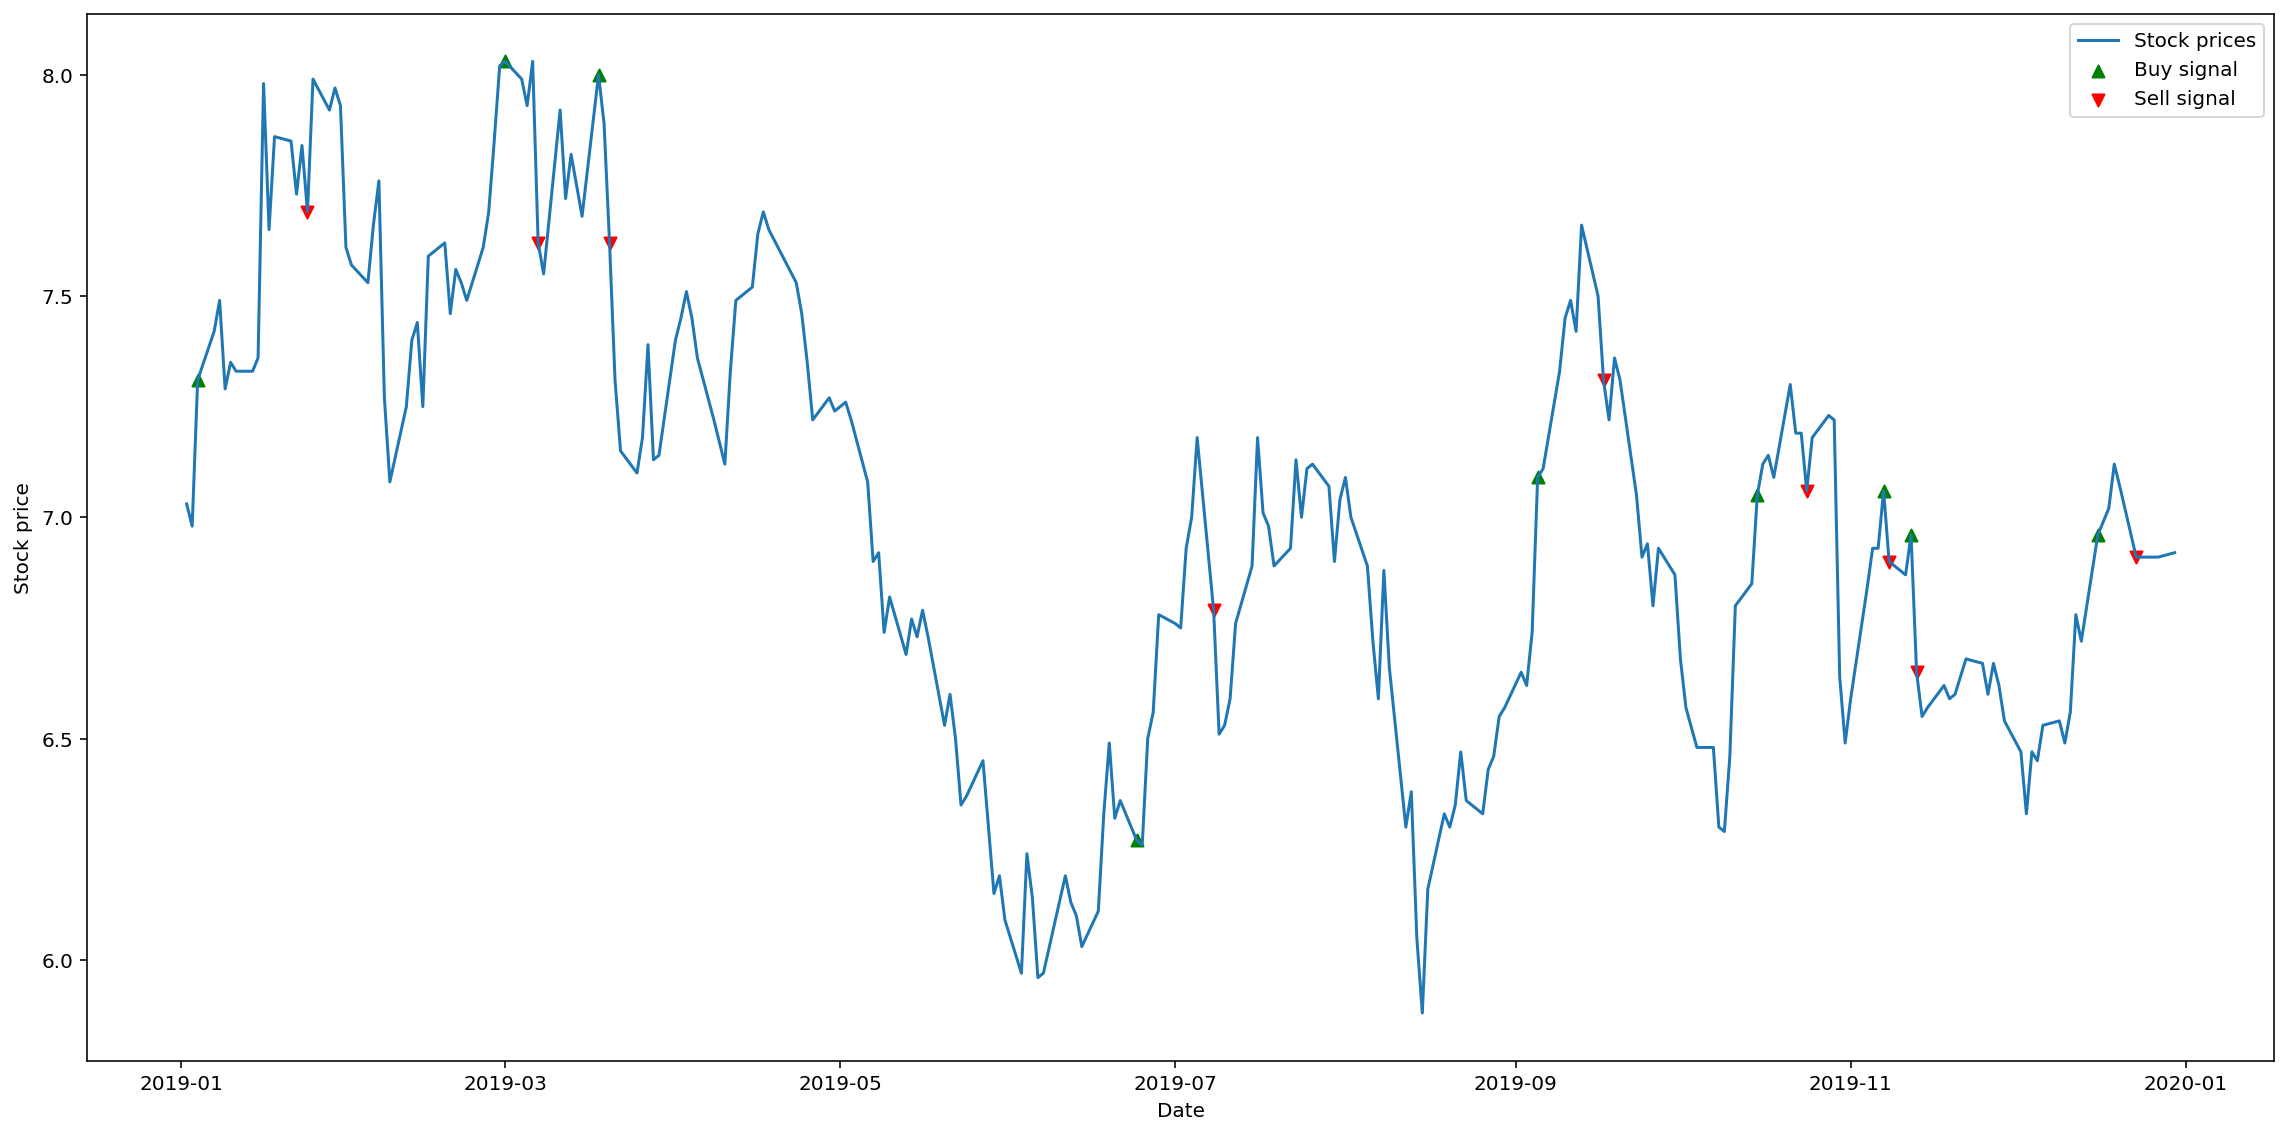

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max  	mean    	std    
0  	1000  	-10.7461	2.826	-3.02285	2.24222
1  	647   	-7.6029 	4.26373	-1.35739	1.68933
2  	648   	-9.63277	4.26373	-0.354615	1.51114
3  	669   	-8.0396 	4.26323	0.254931 	1.57878
4  	659   	-9.63277	4.26323	0.808219 	1.64162
5  	645   	-7.88527	5.07185	1.42195  	1.66862
6  	642   	-9.969  	5.07185	1.90168  	1.84219
7  	637   	-10.6968	4.9805 	2.22801  	1.87332
8  	663   	-10.1814	5.2331 	2.59354  	1.79352
9  	651   	-8.40073	5.2331 	2.69669  	1.87514
10 	655   	-10.0482	5.35865	2.82189  	2.03782
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Best average net profit: 0.6125639872417028
CPU 

In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[109, 226], [12, 36, 124], [242], [32, 5]]
Net profit of strategy: 0.884800
Net profit of buy and hold: 0.314450
Percentage profit of strategy: 6.848297%
Percentage profit of buy and hold: 2.433824%
Number of buy signals: 2
Number of sell signals: 2


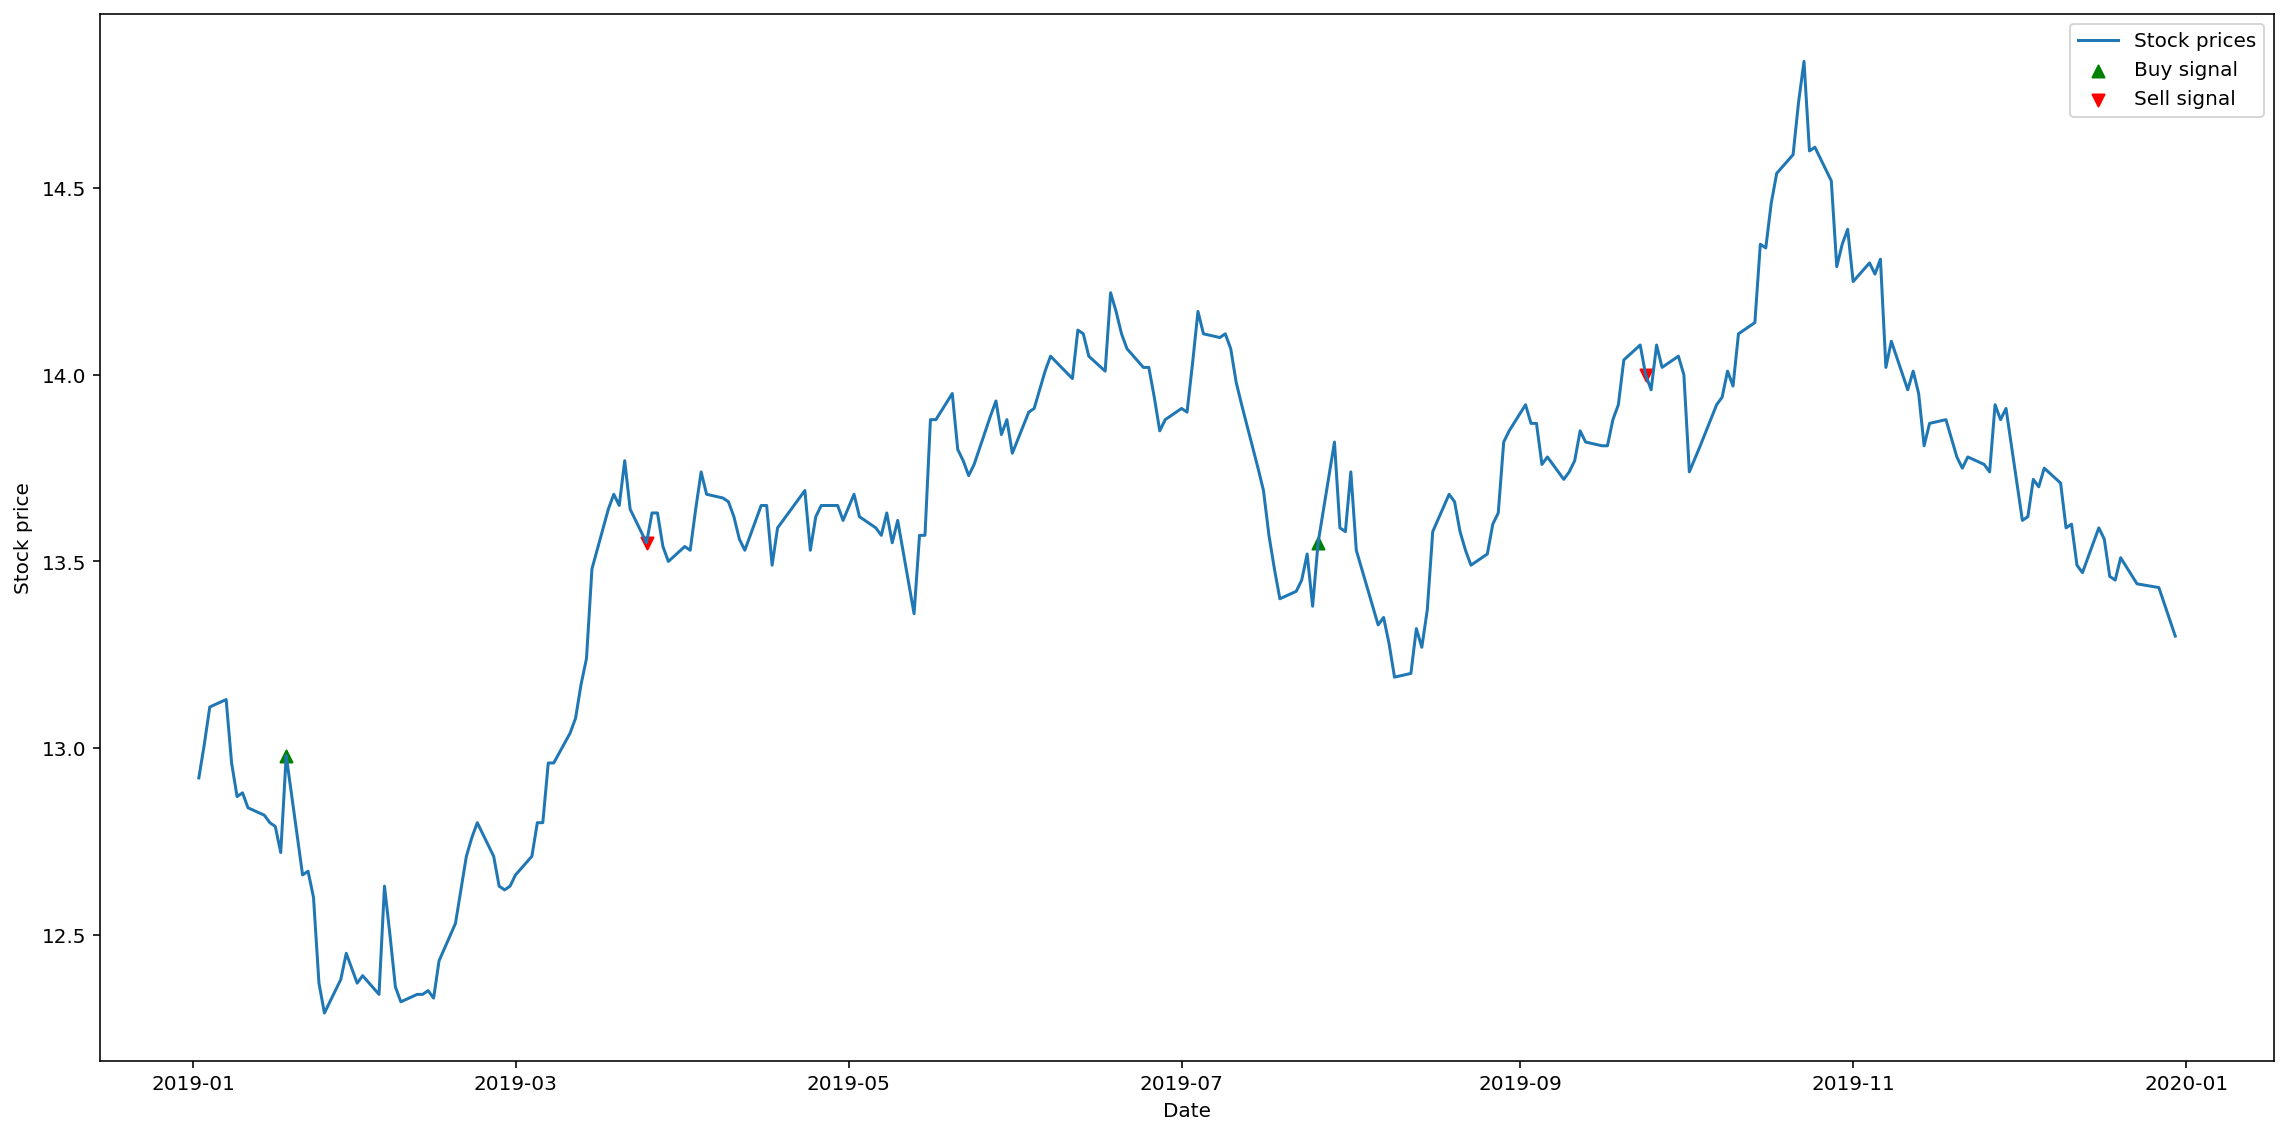

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-79.7186	26.6214	-13.8564	16.2574
1  	647   	-73.5939	26.6214	-2.55825	11.4375
2  	648   	-40.2118	28.3558	3.44677 	10.0258
3  	669   	-42.2204	28.631 	7.37    	9.83827
4  	659   	-49.2366	30.1307	10.0832 	10.5198
5  	645   	-75.559 	35.0239	12.2048 	11.5442
6  	642   	-71.7549	35.1927	14.2594 	11.1002
7  	637   	-75.559 	35.1927	16.0517 	12.2915
8  	663   	-69.5971	35.1927	17.8903 	12.0681
9  	651   	-75.559 	37.8244	19.0124 	12.7314
10 	655   	-75.7885	37.1102	19.7218 	14.4971
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Best average net profit: 7.277998286707372
CPU times:

In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'BollingerBaender']
Active rules' parameters: [[118, 223], [23, 51, 72], [55, 6]]
Net profit of strategy: 6.027375
Net profit of buy and hold: 32.969475
Percentage profit of strategy: 7.229669%
Percentage profit of buy and hold: 39.545970%
Number of buy signals: 2
Number of sell signals: 2


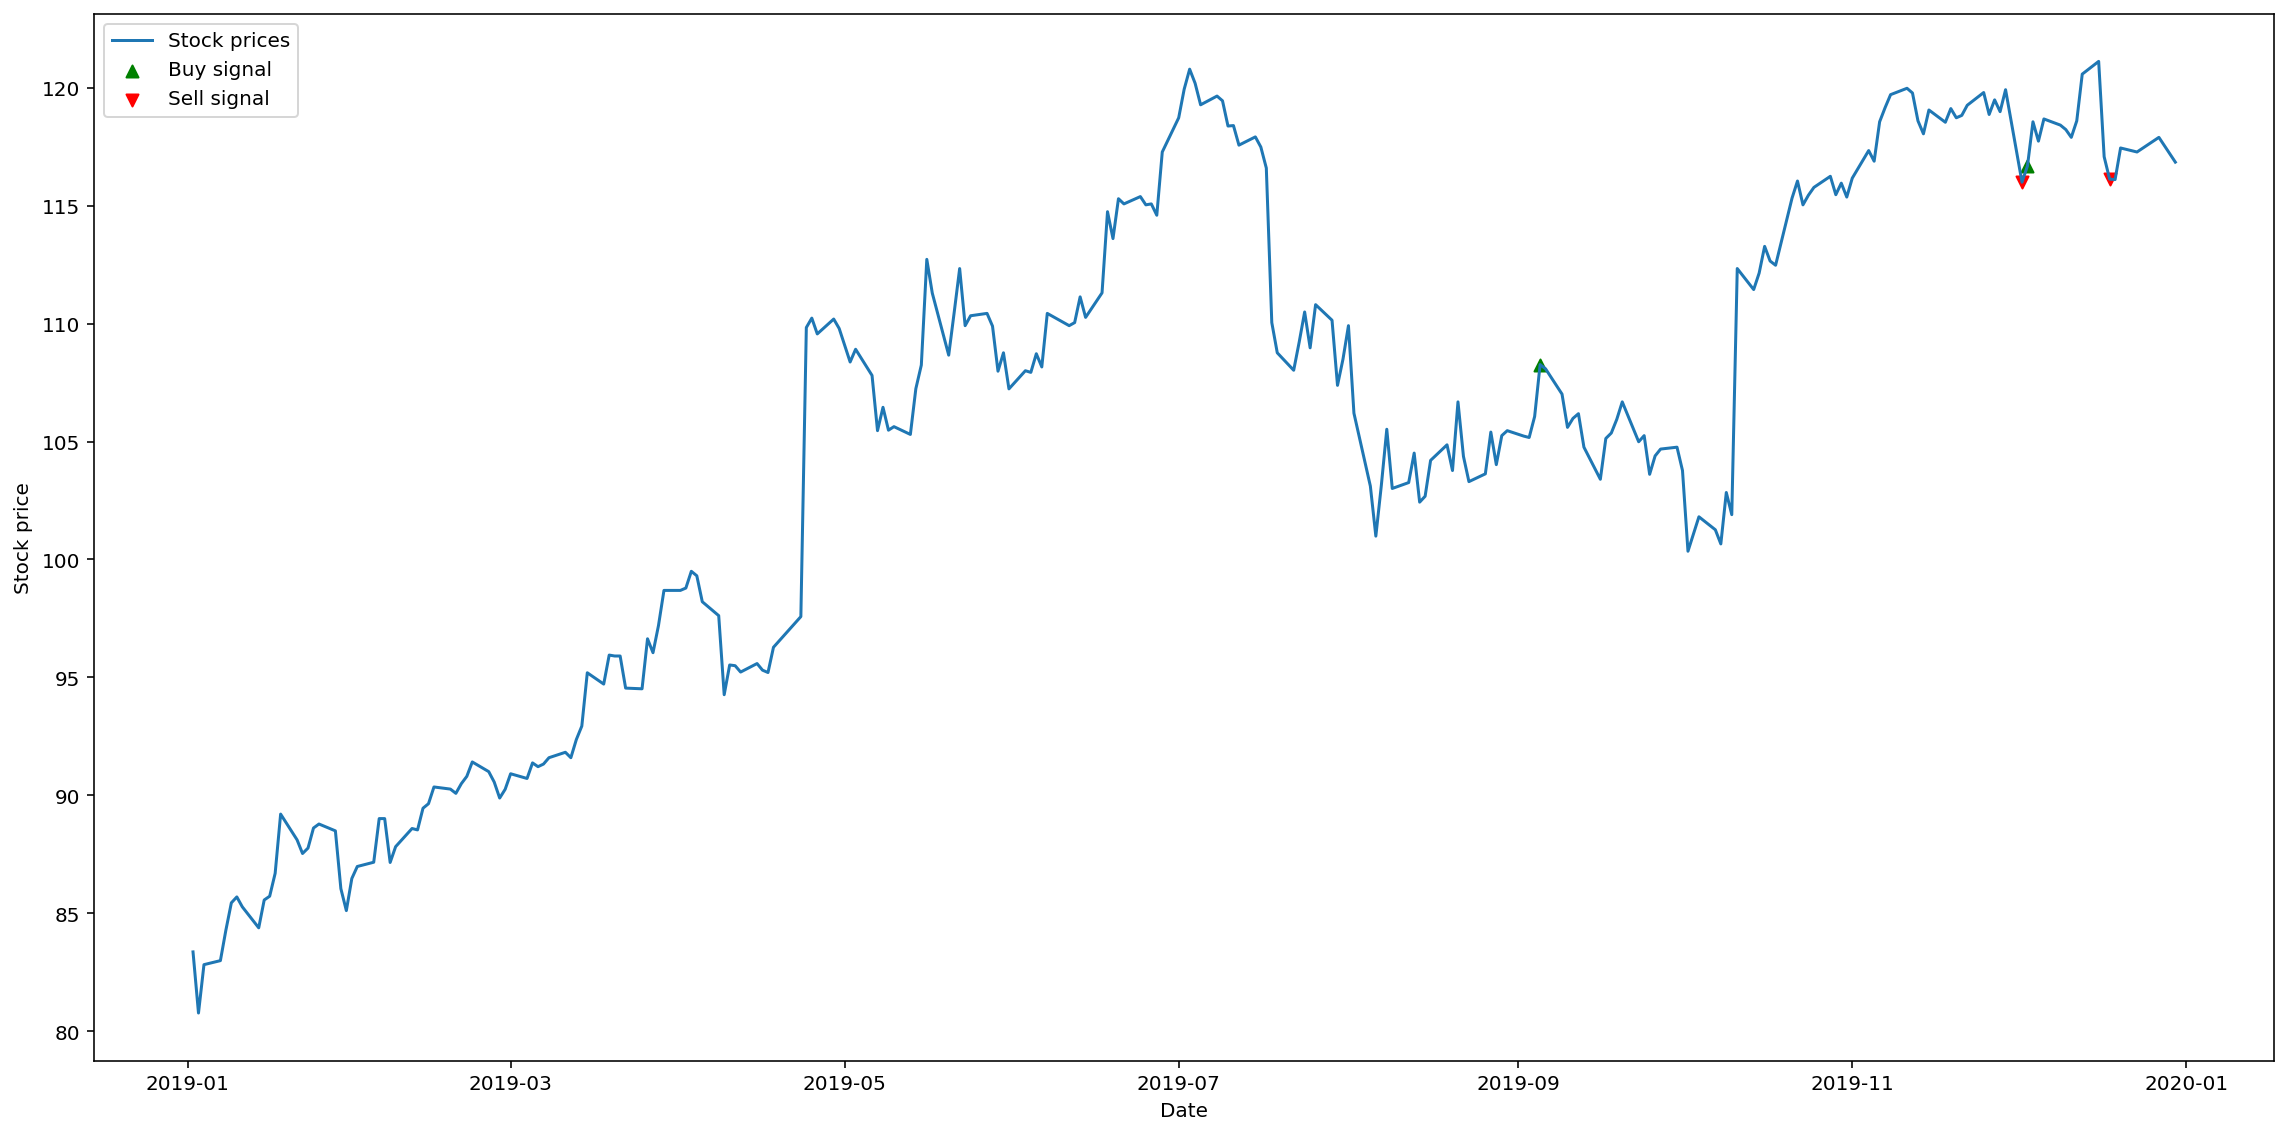

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46	-404.667	3075.28
1  	647   	-9945.13	6545.39	1376.22 	2027.9 
2  	648   	-12697  	7142.06	2388.18 	2060.13
3  	669   	-14101.2	8316.11	3041.42 	2079.32
4  	659   	-9810.66	8316.11	3655.94 	2069.86
5  	645   	-13940.5	8316.11	4228.18 	2078.46
6  	642   	-6774.96	8316.11	4644.19 	2077.4 
7  	637   	-8916.35	9239.82	4955.46 	2275.59
8  	663   	-7377.15	9239.82	5148.17 	2433.54
9  	651   	-4978.7 	9239.82	5485.68 	2503.65
10 	655   	-12284.5	9601.51	5878.2  	2627.64
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Best average net profit: 222.06329731911254
CPU times: user 8

In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'STO', 'MACD', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[185], [32, 183], [63, 25, 45], [206, 102, 42], [188], [59, 3]]
Net profit of strategy: 1590.563000
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 6.814547%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 2
Number of sell signals: 2


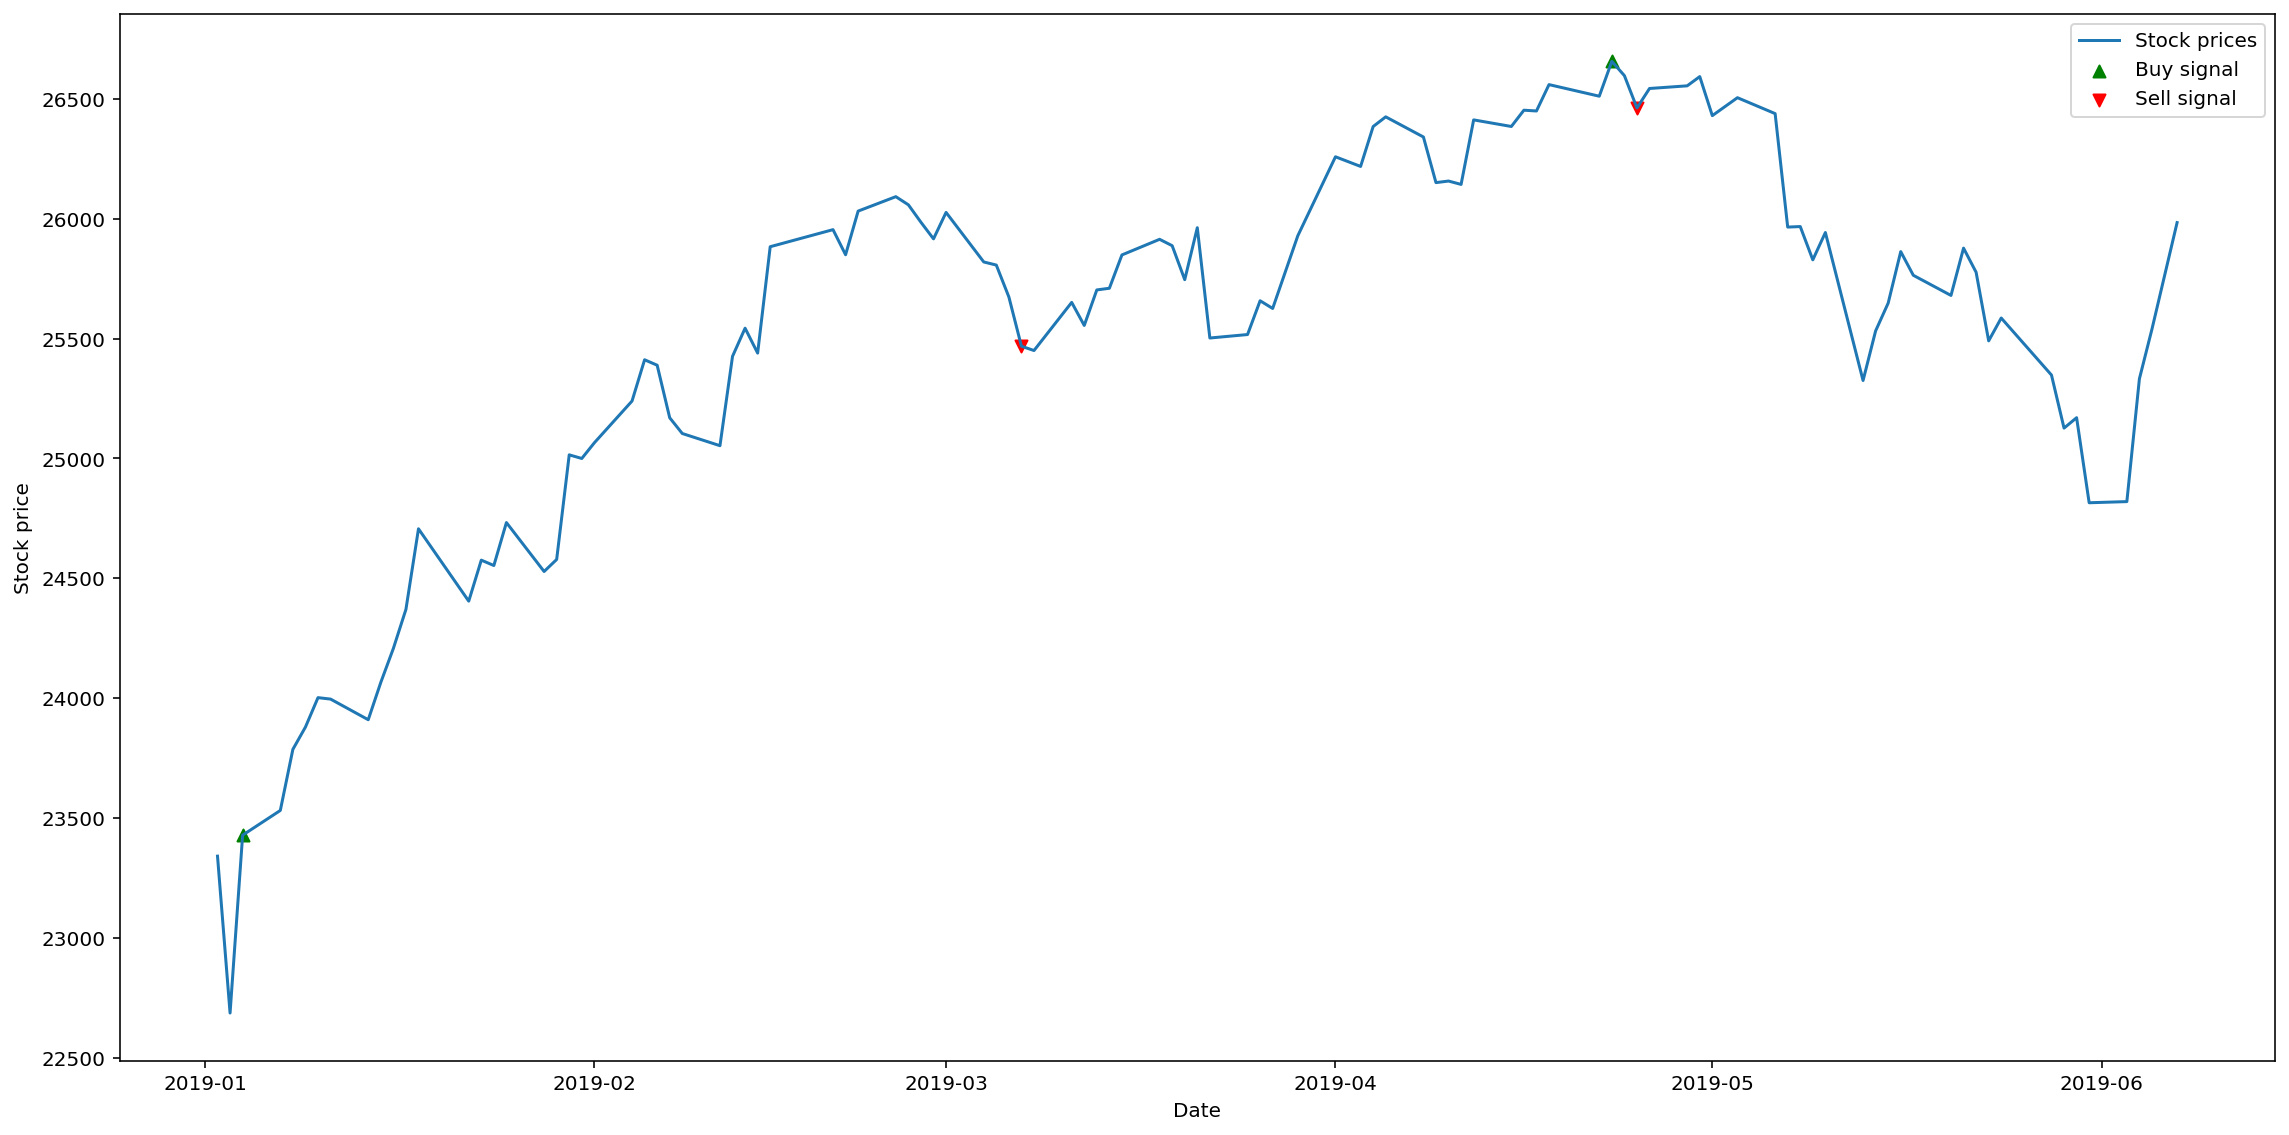

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std    
0  	1000  	-30.2527	18.4991	-0.334673	6.64861
1  	647   	-27.8999	18.1699	3.58347  	5.41655
2  	648   	-28.57  	18.1699	6.52236  	5.13661
3  	669   	-19.3751	19.0814	8.99569  	5.3376 
4  	659   	-28.7245	19.0814	11.207   	5.38545
5  	645   	-18.615 	19.1917	13.4401  	4.82149
6  	642   	-28.864 	19.4154	14.4481  	4.85751
7  	637   	-13.1565	20.6609	15.2331  	4.11426
8  	663   	-8.02272	20.6609	15.3958  	4.38566
9  	651   	-28.864 	21.337 	15.6744  	4.7022 
10 	655   	-10.1714	21.337 	16.2072  	4.55766
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]
Best average net profit: 4.79959702058898

In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[7, 115, 88], [27, 3]]
Net profit of strategy: -0.970500
Net profit of buy and hold: 5.462050
Percentage profit of strategy: -2.381595%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 1
Number of sell signals: 1


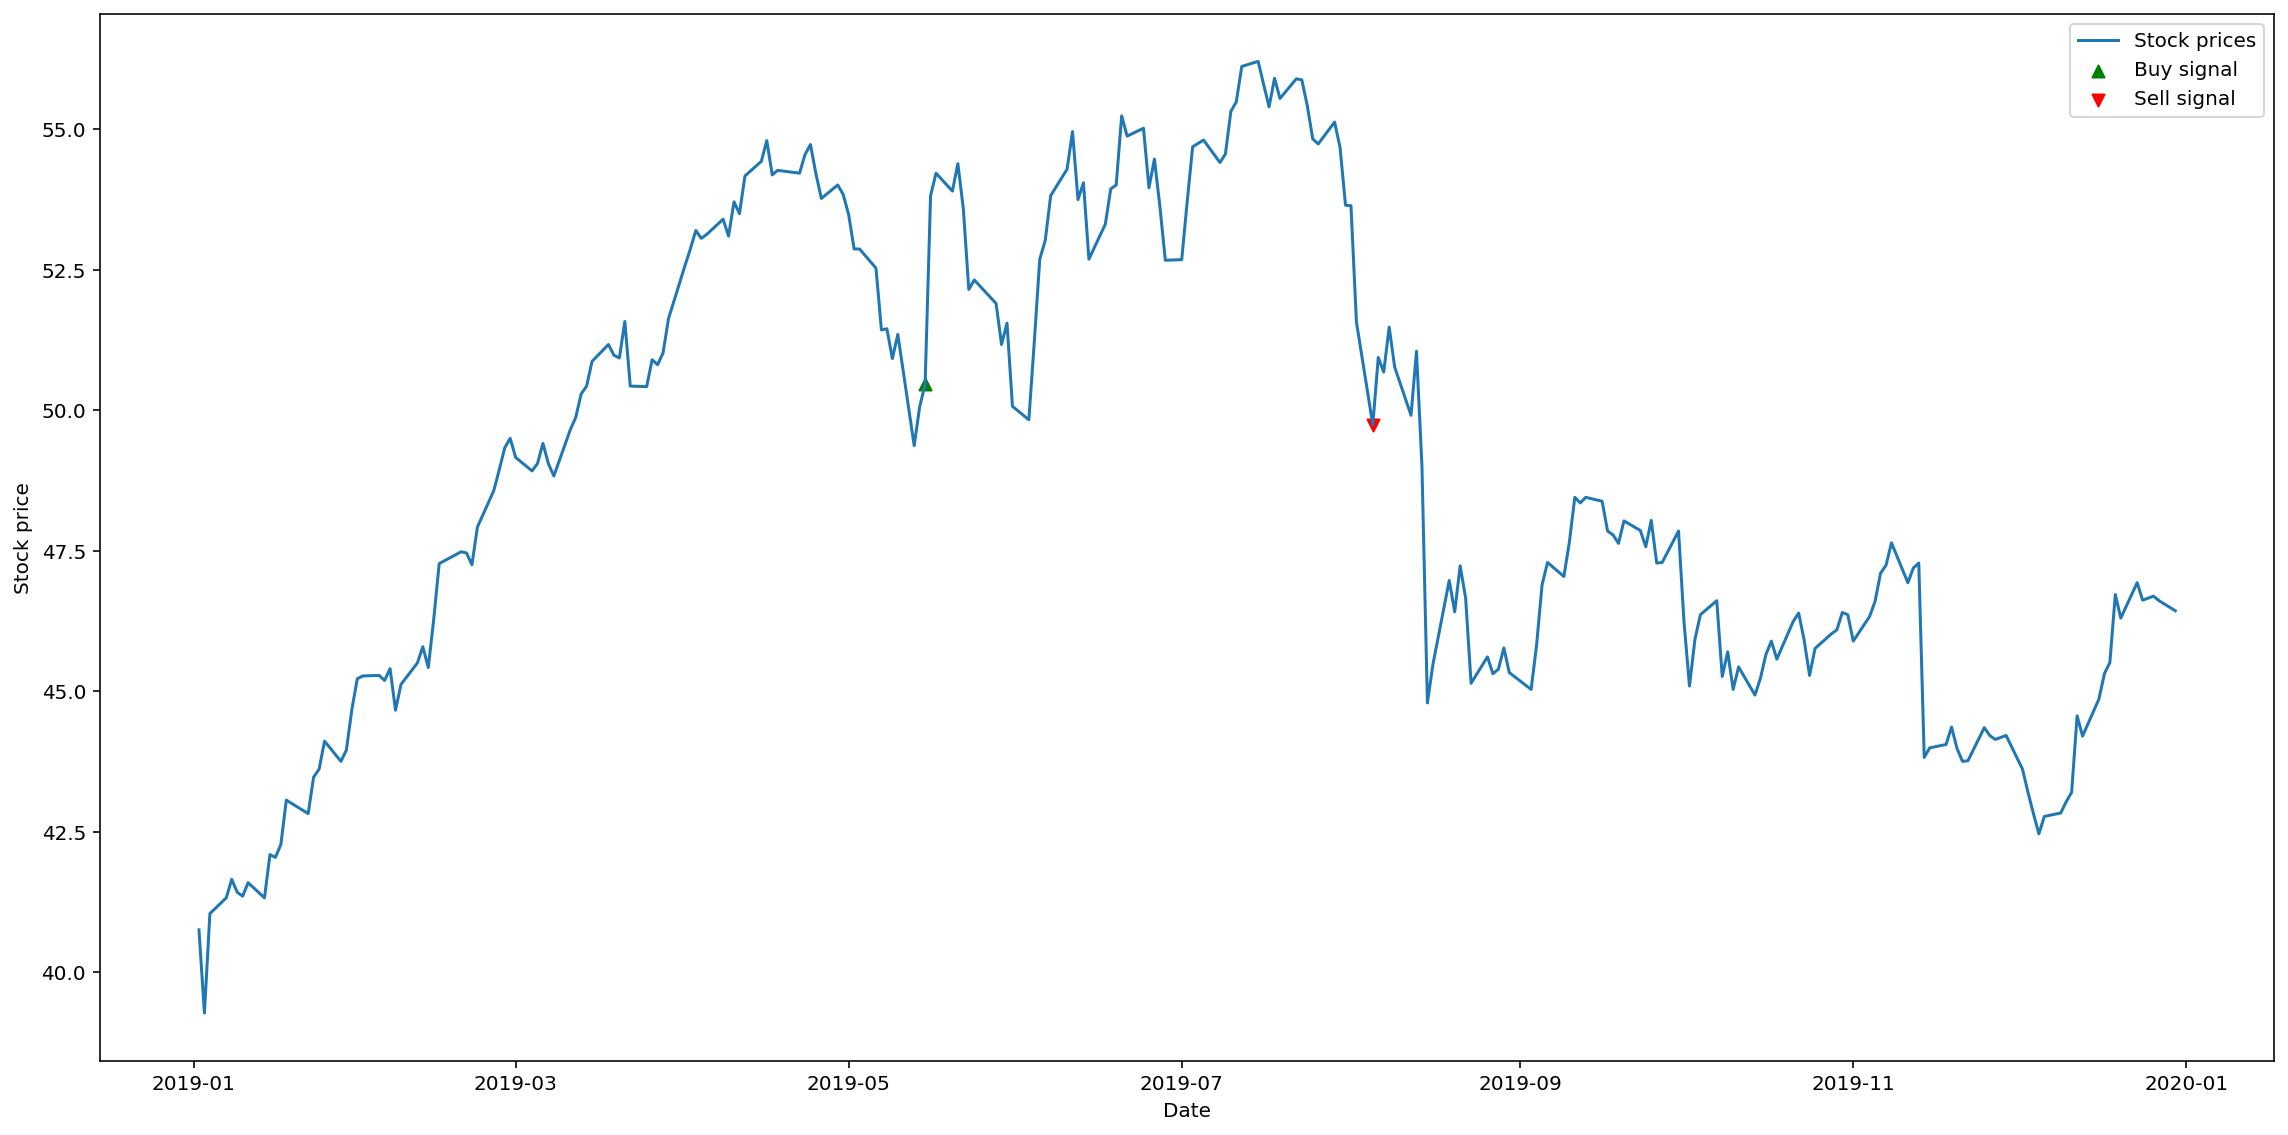

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-74.4476	25.2777	-17.3998	14.5641
1  	647   	-74.0175	23.2855	-7.93464	11.4154
2  	648   	-71.8792	23.6498	-1.57176	11.2576
3  	669   	-75.9978	29.8711	3.64463 	10.0904
4  	659   	-76.794 	29.8711	7.06575 	11.3253
5  	645   	-71.8792	40.6748	10.8391 	11.1506
6  	642   	-71.8792	40.6748	13.5856 	10.7488
7  	637   	-71.8792	42.2132	15.6967 	12.2568
8  	663   	-72.7027	43.9103	18.7131 	11.8303
9  	651   	-72.833 	43.9103	21.4565 	11.977 
10 	655   	-72.7027	45.8537	23.8126 	13.5094
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0]
Best average net profit: 8.708845738188723
CPU times:

In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 53, 91], [28, 4]]
Net profit of strategy: -4.861000
Net profit of buy and hold: -13.107875
Percentage profit of strategy: -6.572472%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 2
Number of sell signals: 2


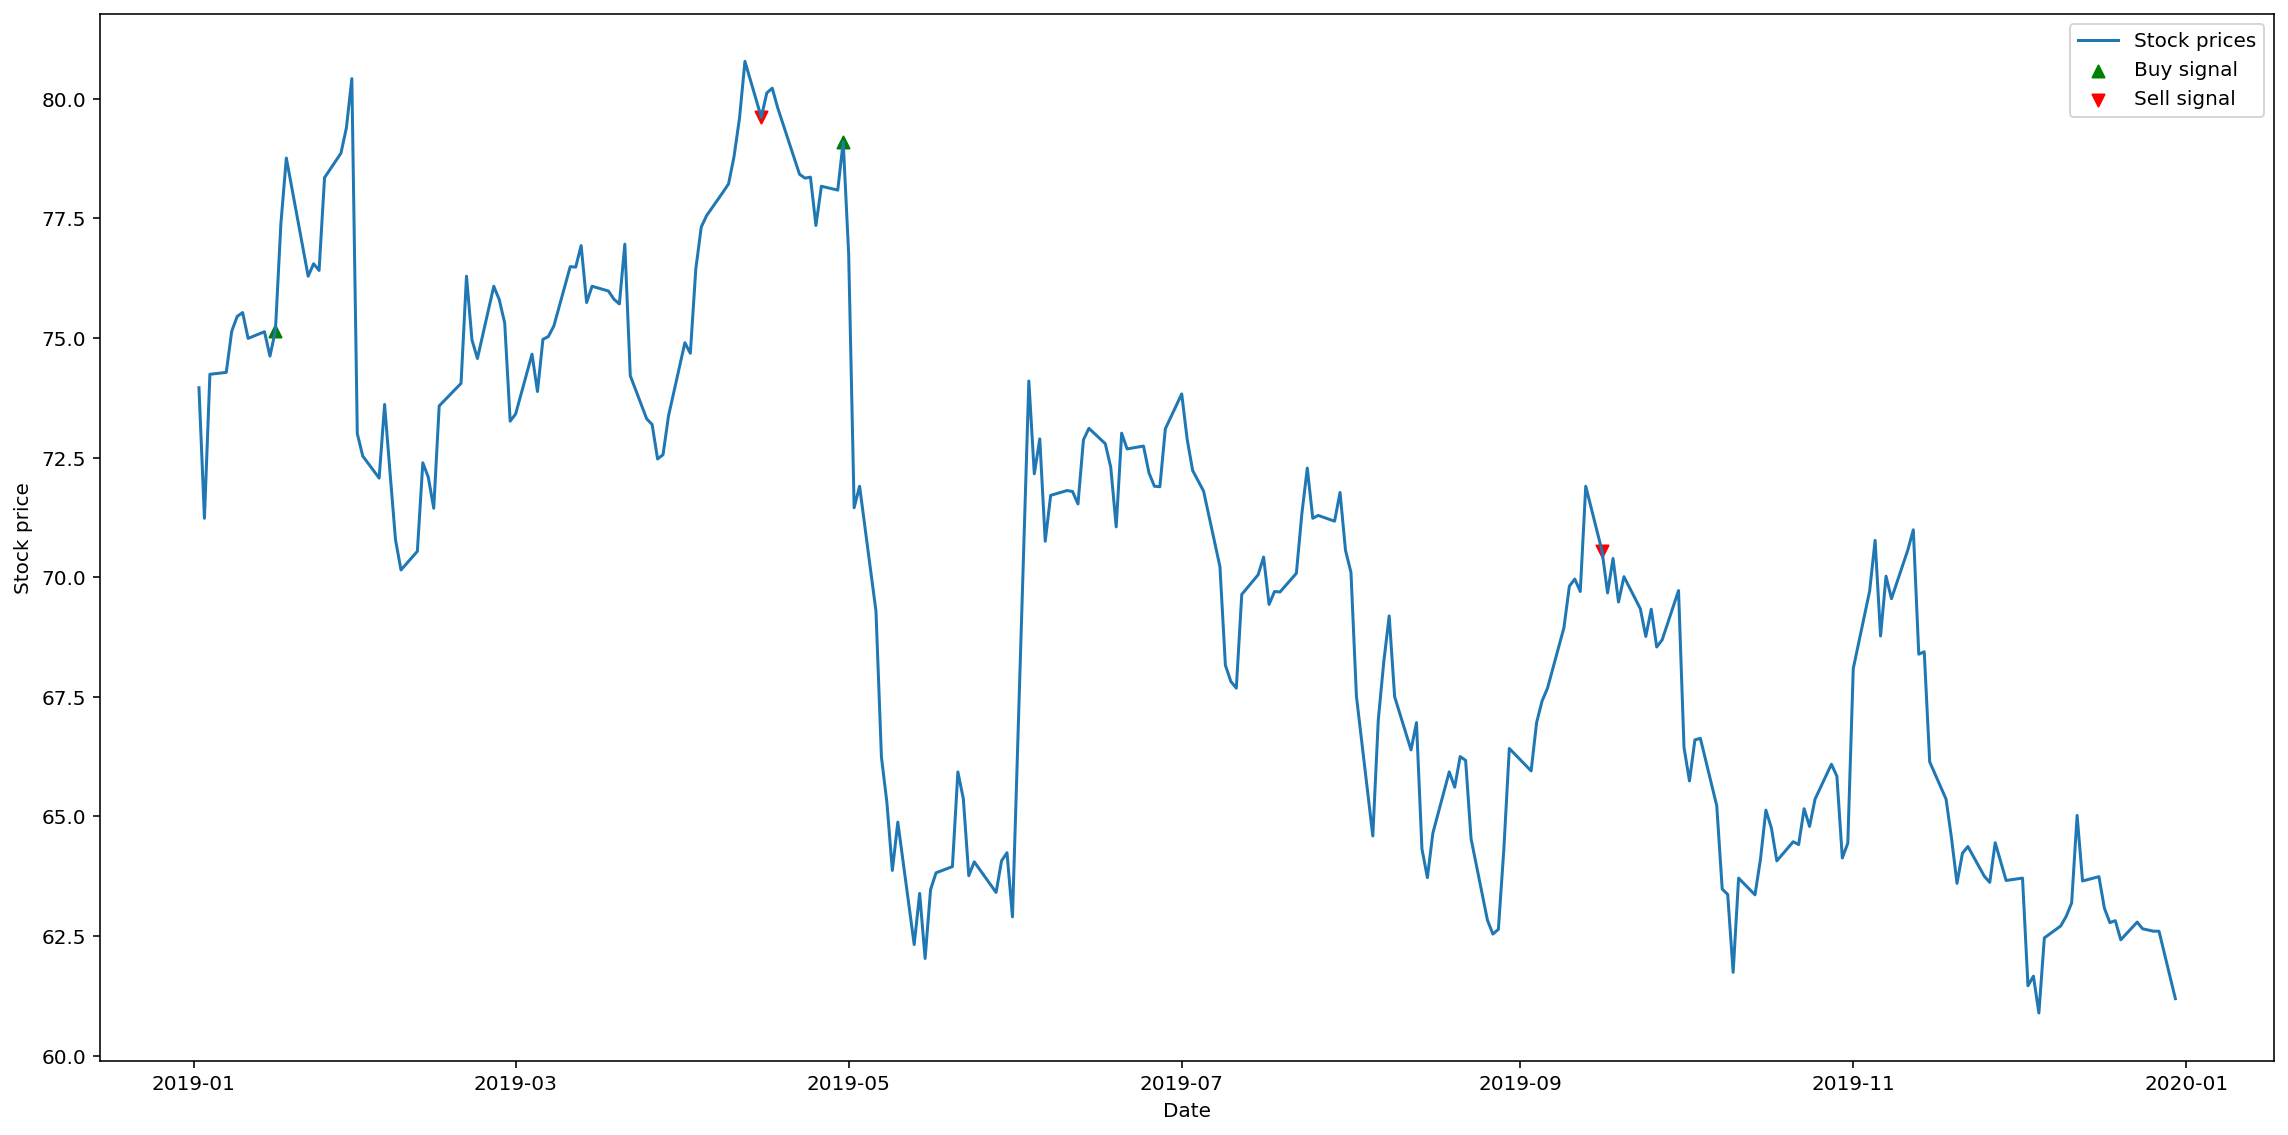

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	647   	-68.5956	42.7461	7.86333	11.7589
2  	648   	-72.8102	46.1583	13.4008	11.3778
3  	669   	-45.5372	50.7906	18.3404	11.0528
4  	659   	-70.1652	50.7906	21.6321	11.9032
5  	645   	-70.69  	50.7906	25.314 	11.2879
6  	642   	-71.2846	50.7906	27.126 	11.7727
7  	637   	-76.599 	54.0269	28.66  	13.0731
8  	663   	-71.3309	59.0606	30.2554	14.2618
9  	651   	-35.5303	59.0606	31.6316	15.508 
10 	655   	-70.2533	59.0606	33.5797	16.1484
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0]
Best average net profit: 5.283386731248652
CPU times: user 7min 32s, sys: 

In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['MACD', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[60, 53, 52], [77, 53, 27], [216], [19, 6]]
Net profit of strategy: -0.986625
Net profit of buy and hold: 40.648000
Percentage profit of strategy: -1.051951%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 3
Number of sell signals: 3


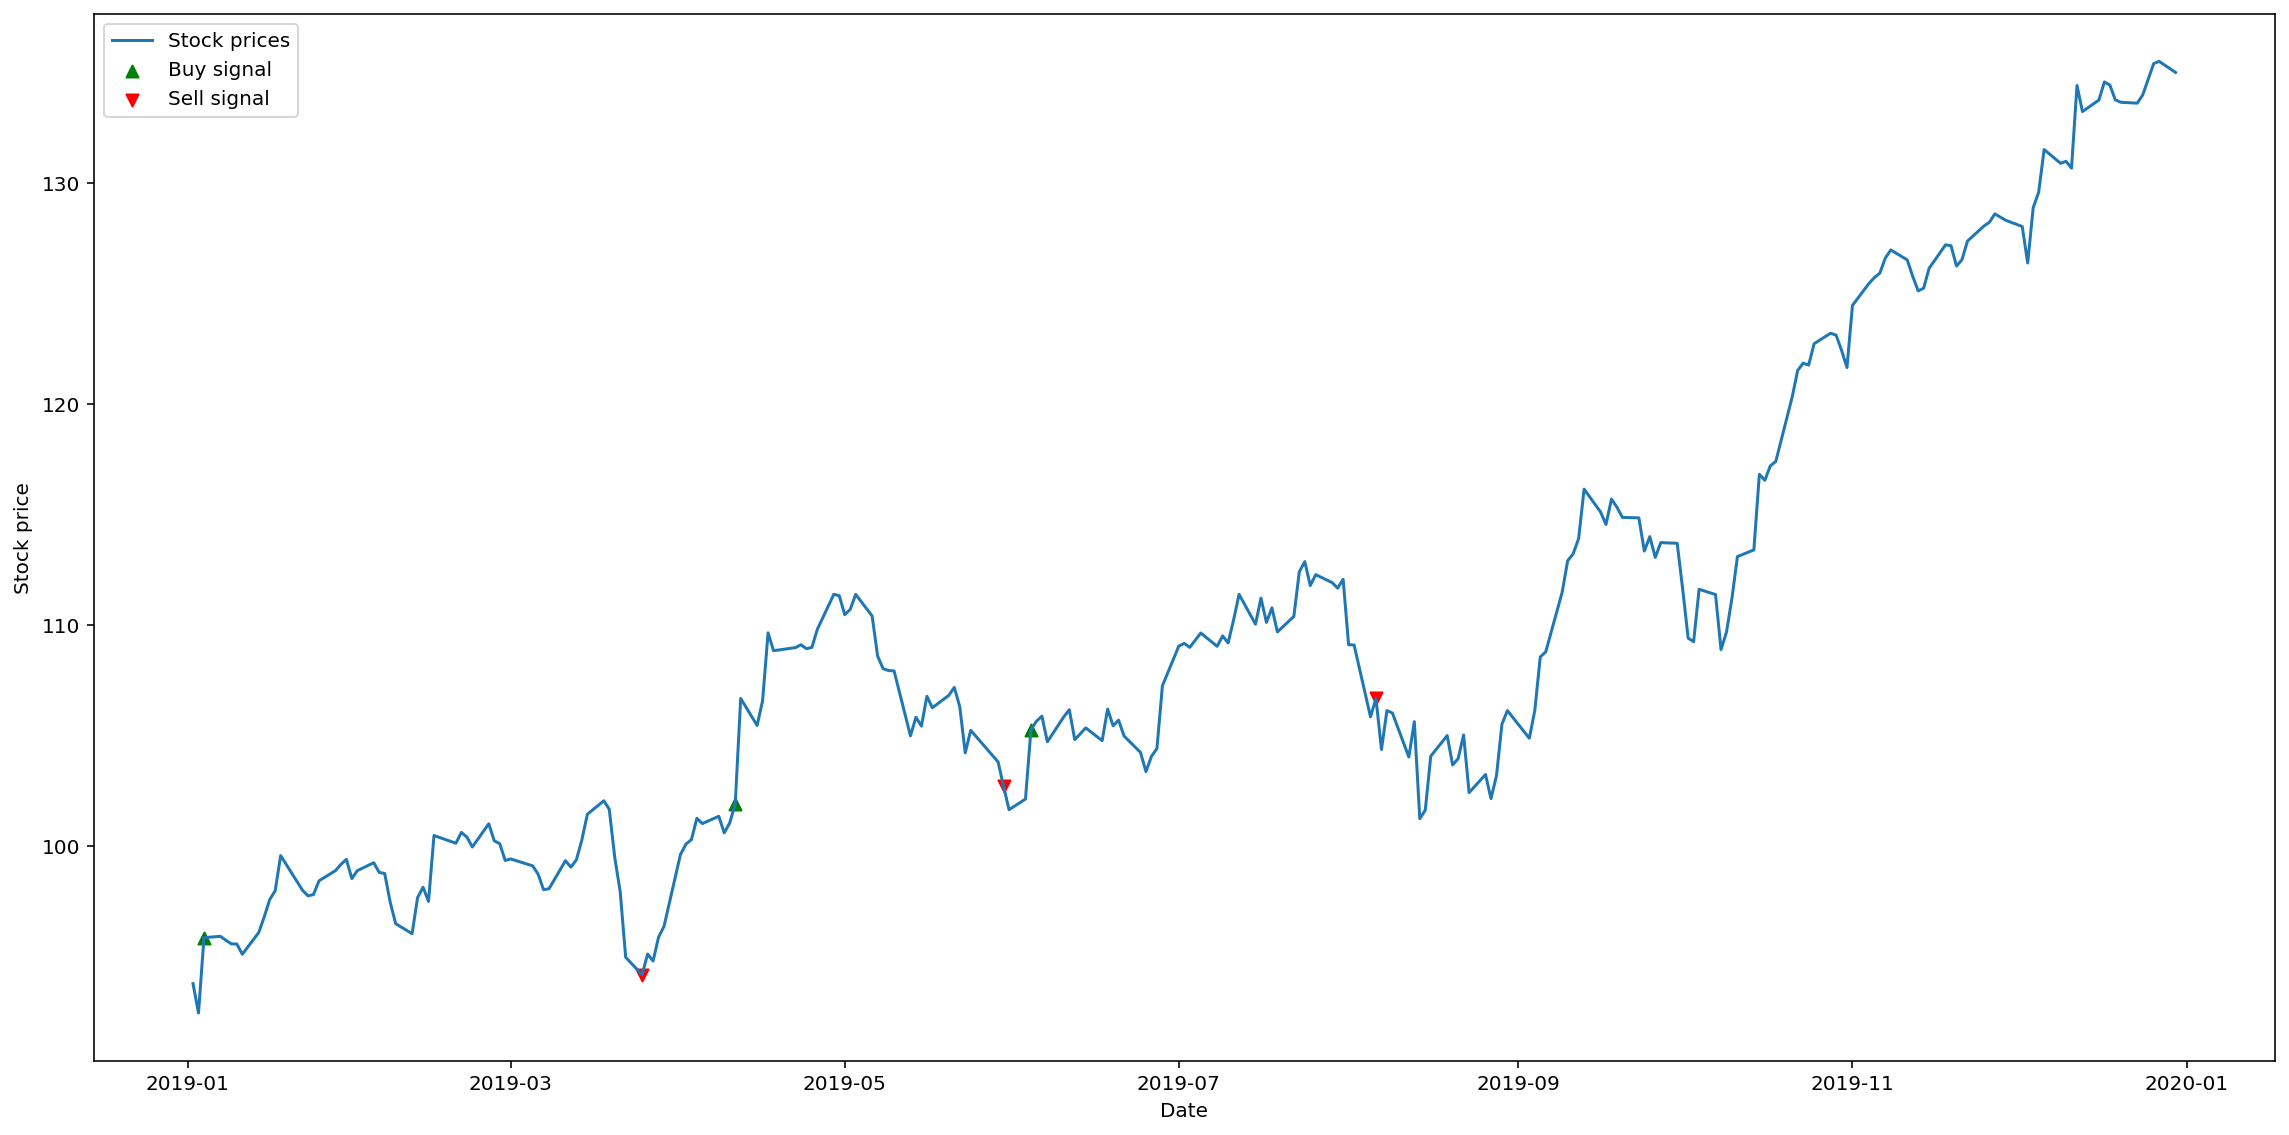

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-90.2665	44.3764	-13.9853	18.9319
1  	647   	-87.2022	50.3406	-1.07631	17.3366
2  	648   	-81.5542	50.3406	9.14897 	18.6095
3  	669   	-83.7469	50.3406	20.5692 	19.8821
4  	659   	-87.2022	51.0385	31.4199 	17.5118
5  	645   	-84.9165	54.4303	37.1202 	16.2287
6  	642   	-87.1601	54.4303	38.8868 	17.1411
7  	637   	-84.9165	54.4303	40.5265 	17.6636
8  	663   	-87.2022	54.4303	41.6617 	18.1133
9  	651   	-47.9209	54.7691	43.5567 	16.4421
10 	655   	-90.1293	54.7691	43.8411 	17.6672
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Best average net profit: 0.3955998675877657
CPU times

In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[66, 56, 111], [123], [33, 2]]
Net profit of strategy: 8.290850
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 8.386456%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 1
Number of sell signals: 1


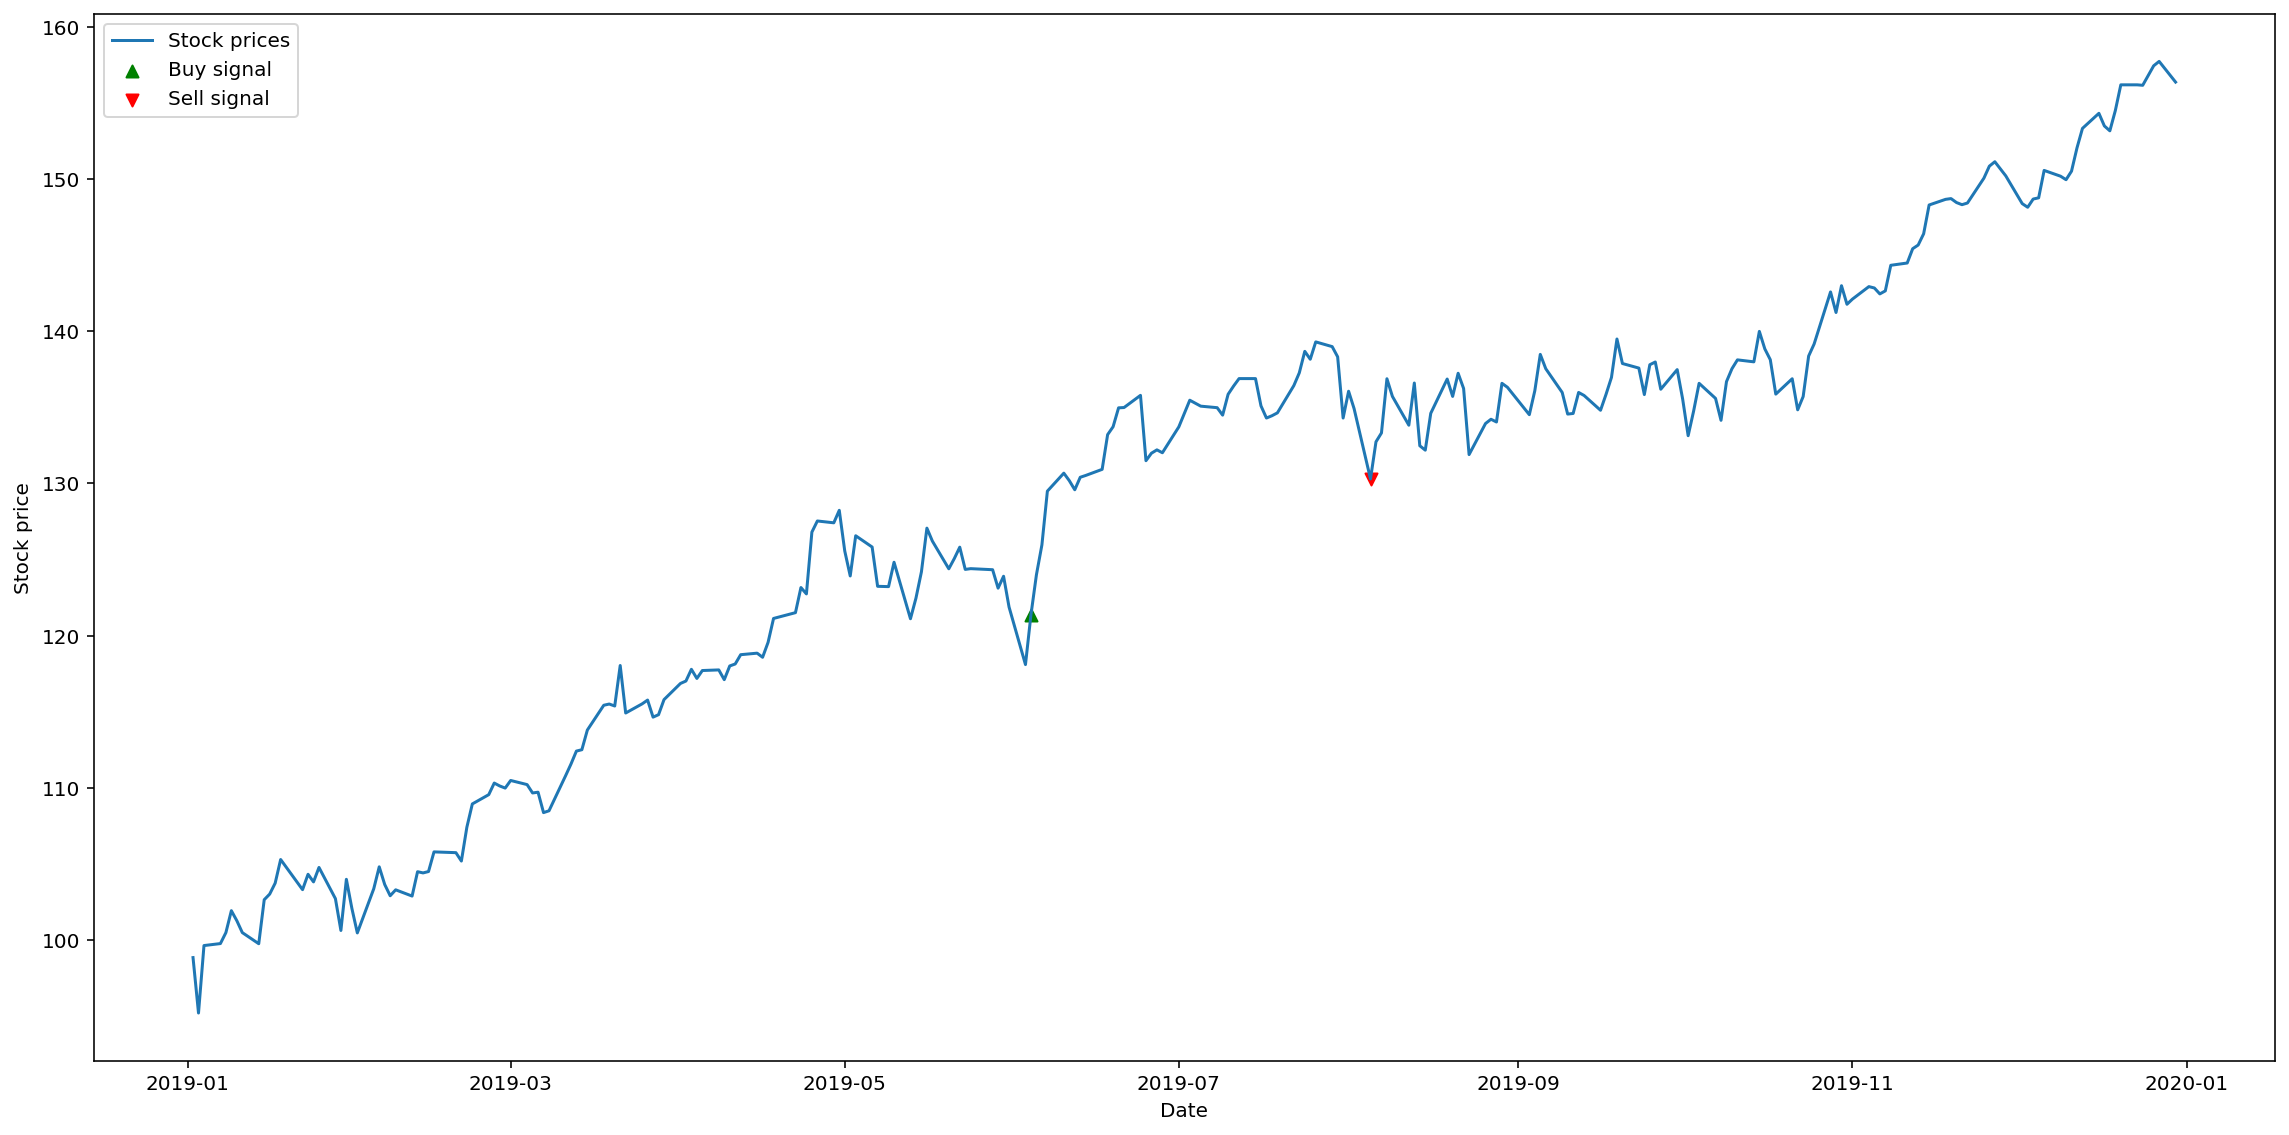

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213	-15.7115	13.7108
1  	647   	-74.4536	24.633 	-6.11158	9.96536
2  	648   	-75.1182	27.1156	-0.608218	9.55817
3  	669   	-73.9658	27.1156	3.32626  	9.62965
4  	659   	-74.1852	28.694 	6.81589  	10.4463
5  	645   	-73.9857	33.7318	10.7518  	10.5252
6  	642   	-73.9857	33.7318	13.7619  	10.9066
7  	637   	-40.9883	34.126 	16.9258  	10.7383
8  	663   	-73.9857	33.8431	19.3344  	11.8796
9  	651   	-37.5488	34.5603	21.9692  	11.2102
10 	655   	-40.6161	34.6988	22.5366  	12.1306
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Best average net profit: 0.0
CPU times: user 8min 28s

In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2019-01-01', end='2019-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[168, 45, 58], [35, 5]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 26.878025
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 36.950818%
Number of buy signals: 0
Number of sell signals: 0


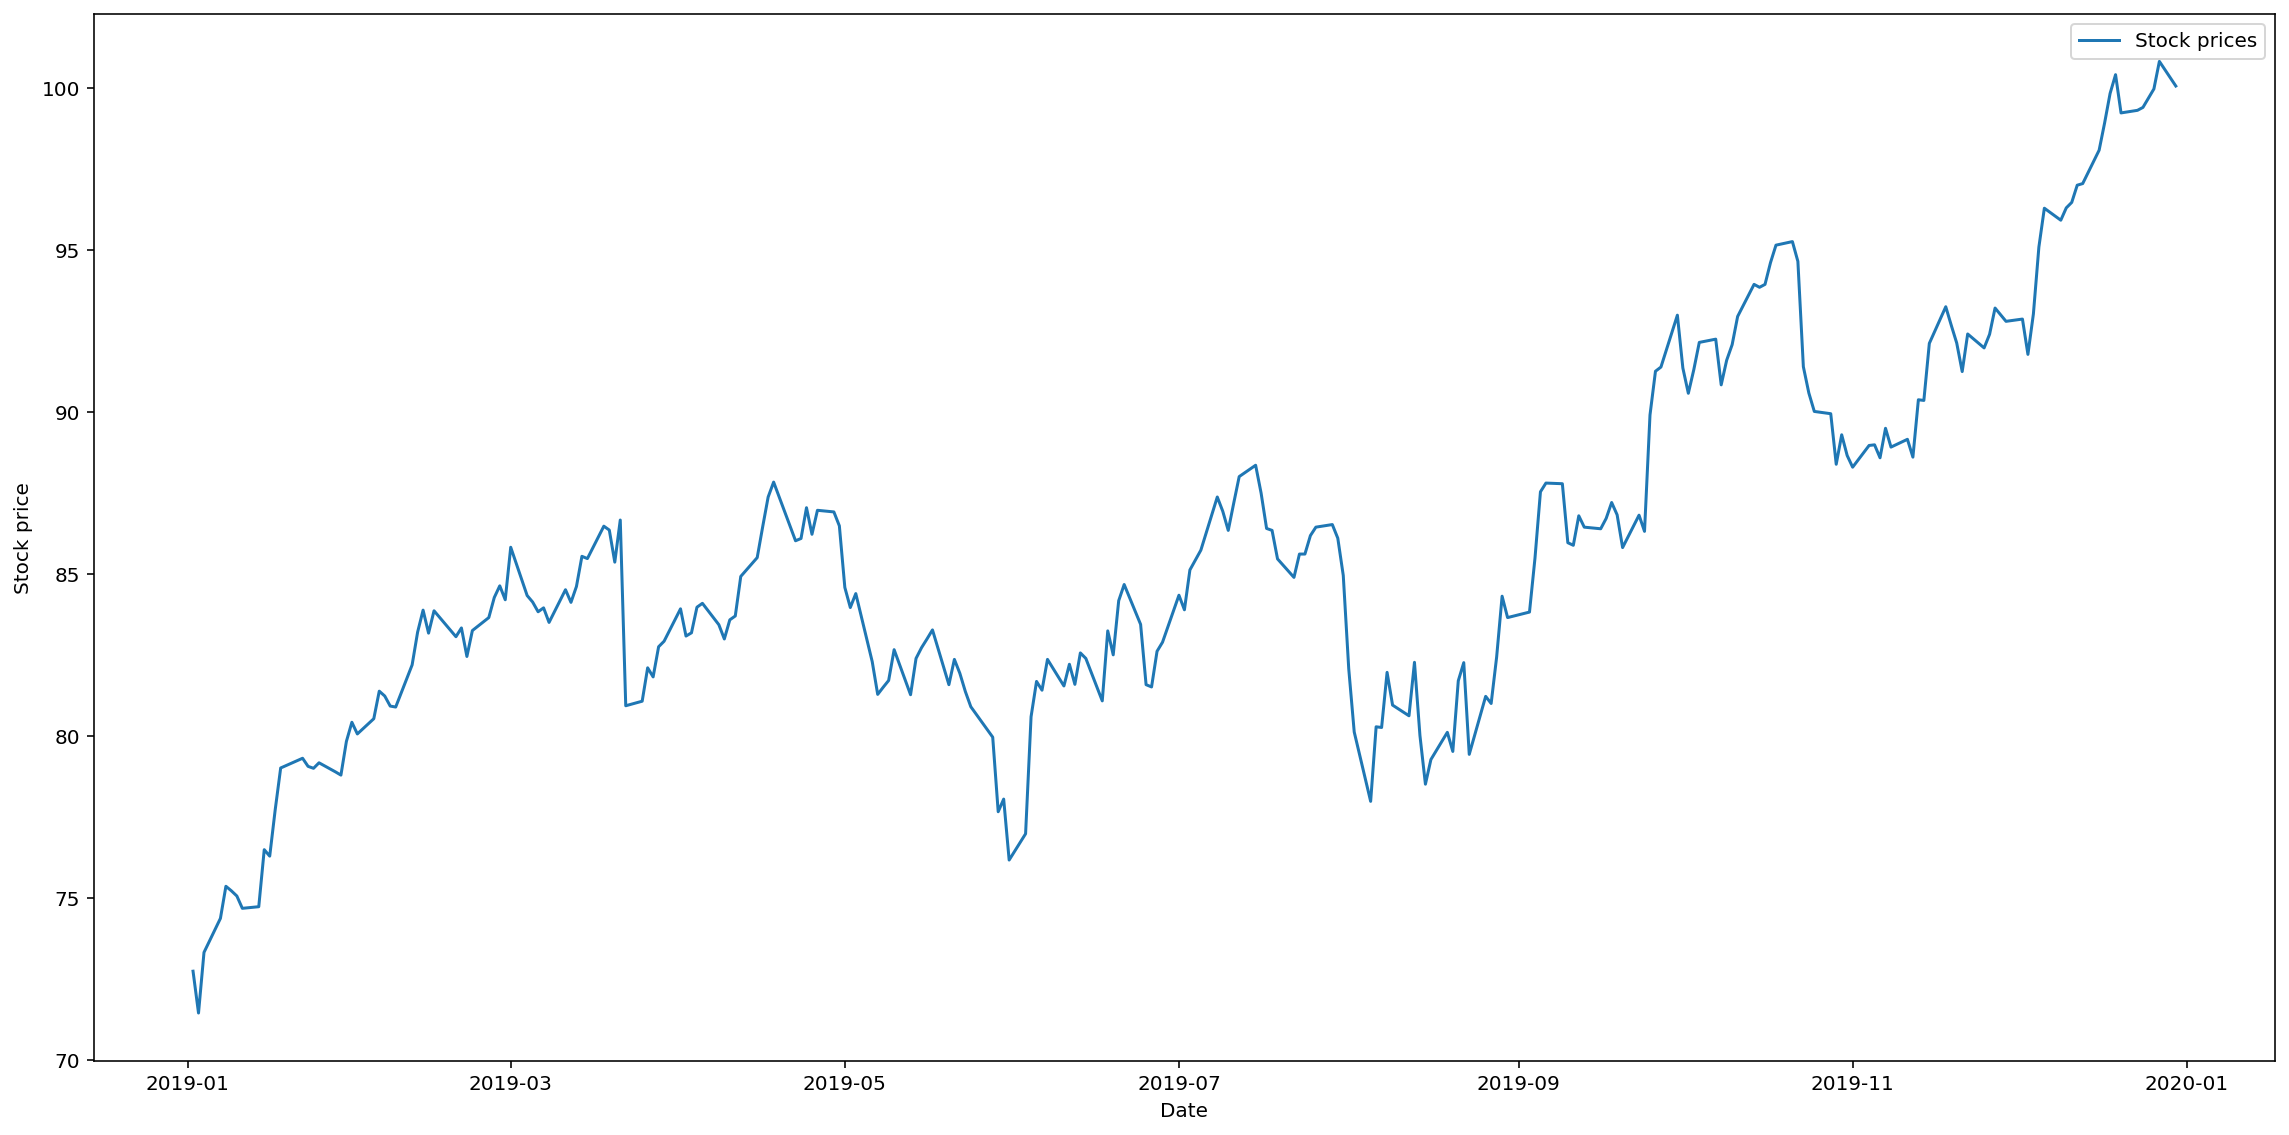

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=10)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	647   	-55.3134	133.353	28.8446	39.0629
2  	648   	-83.6754	133.353	50.553 	44.1899
3  	669   	-69.6497	133.353	75.1767	46.1746
4  	659   	-49.1791	136.581	101.177	40.7868
5  	645   	-85.1856	133.353	116.176	33.5746
6  	642   	-61.7562	133.353	118.283	35.1804
7  	637   	-76.264 	133.353	118.011	37.9221
8  	663   	-48.3433	133.353	120.42 	34.7737
9  	651   	-46.7955	133.353	121.51 	33.8096
10 	655   	-73.4602	133.353	123.053	33.1785
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 20.619852213772287
CPU times: user 8min 

In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[155], [38, 85, 126], [176], [12, 7]]
Net profit of strategy: -37.436175
Net profit of buy and hold: 52.403650
Percentage profit of strategy: -15.835276%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 11
Number of sell signals: 11


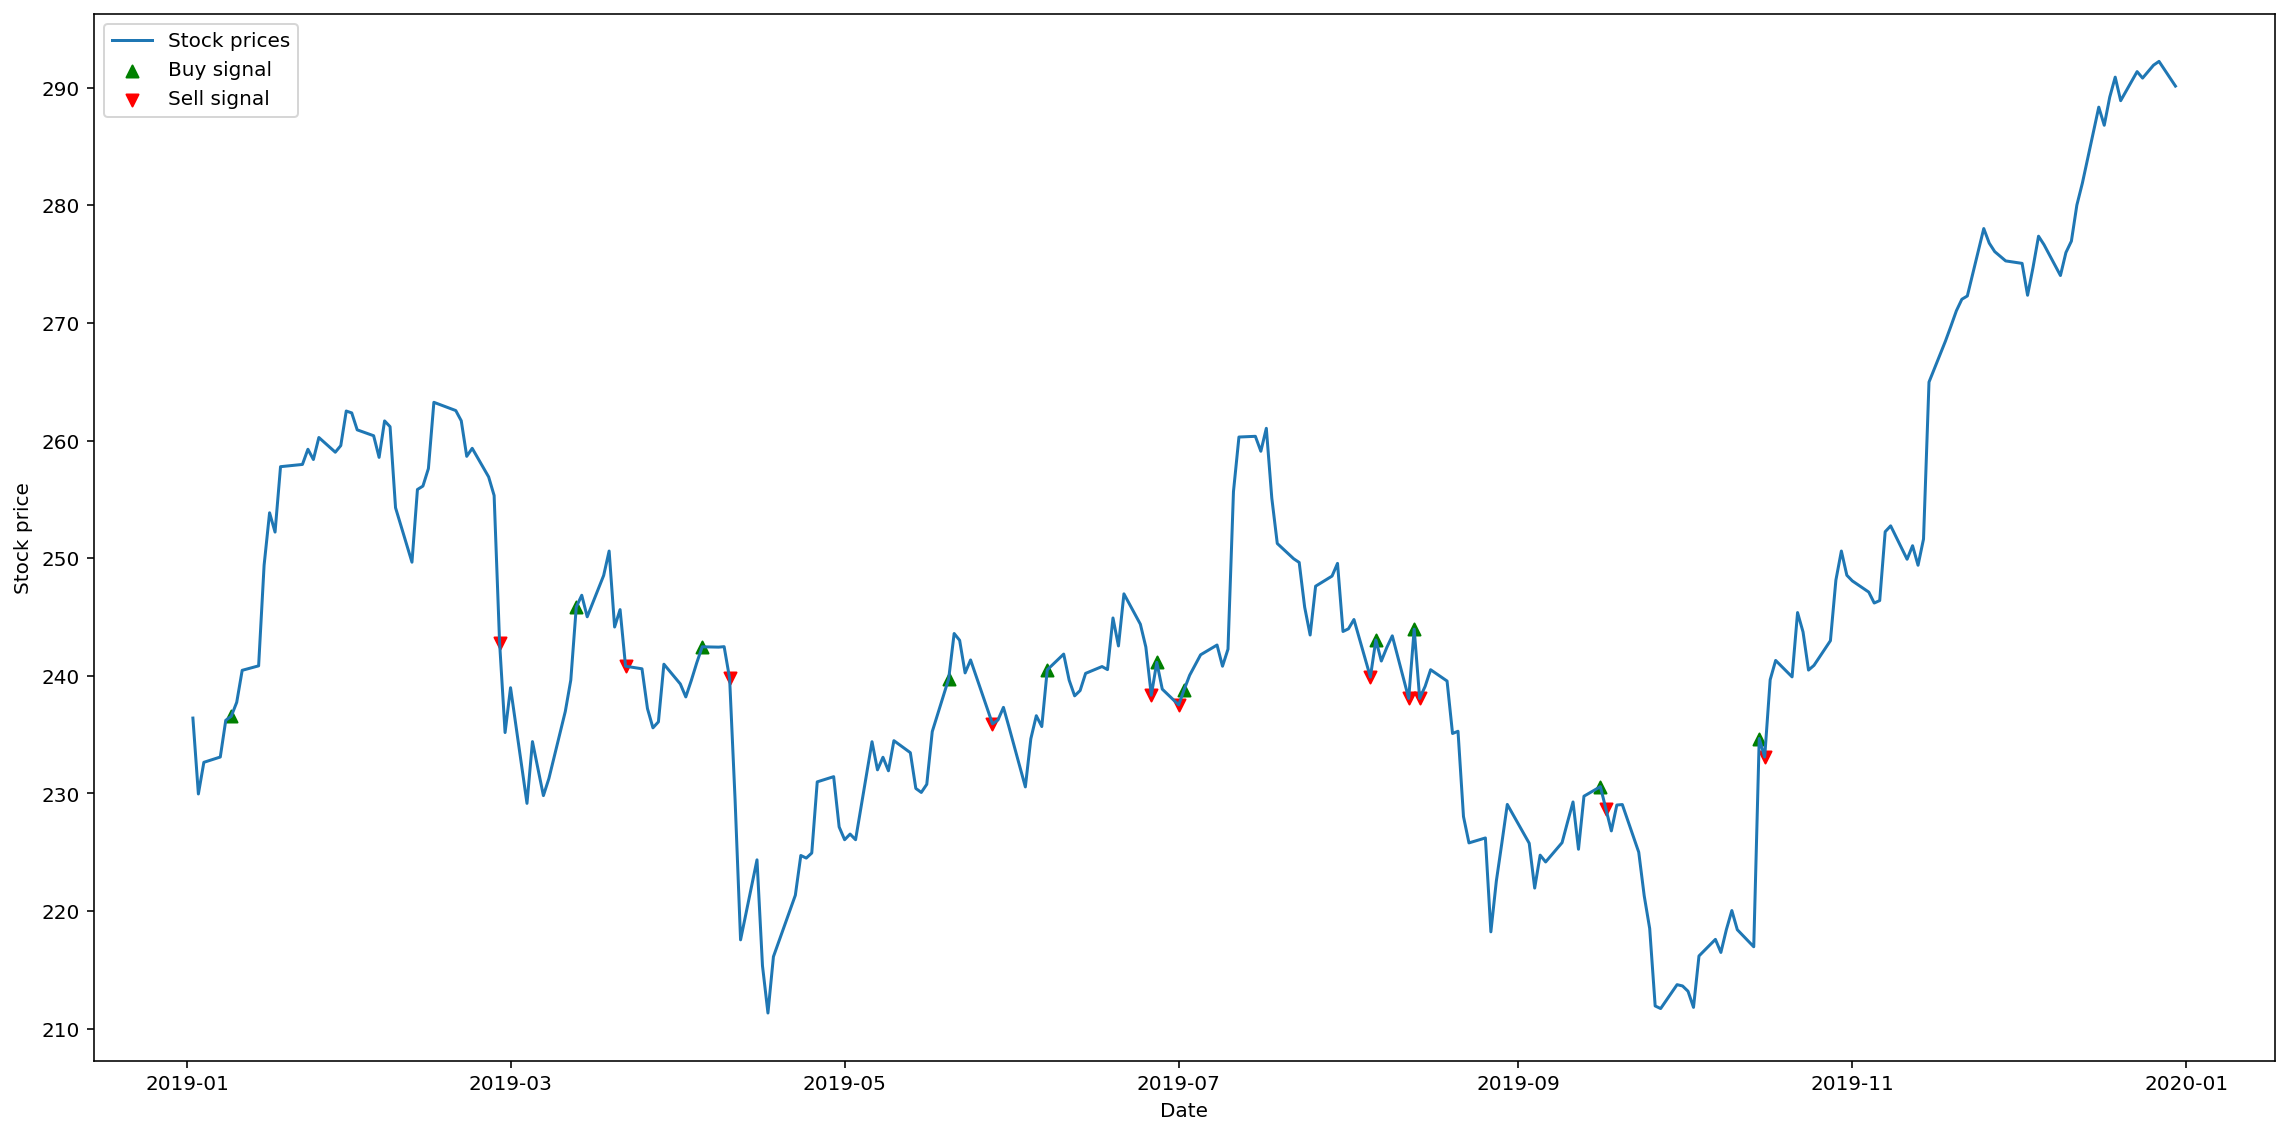

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[0.0, 24.010750329091714]","[5.799582258607222, 58.64860659414599]","[0.0, 29.842999999999996]","[12.896051332675224, 15.491510365251738]","[-7.157894736842, -2.060810810810815]","[6.848297213622288, 2.4338235294117707]","[7.229668945663925, 39.54596977329974]","[6.814547121551587, 10.796113655545895]","[-2.381595092024537, 13.403803680981593]","[-6.572471606273654, -17.72292455381287]","[-1.0519511675018947, 43.339375199914684]","[8.386455593768954, 57.507561197653246]","[0.0, 36.95081798185318]","[-15.835275580559365, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

1.0696724487634106

In [52]:
np.mean(bh_results)

23.882430279472867